# [Lecture 09 - Modeling Events](https://www.youtube.com/watch?v=Zi6N3GLUJmw)

In [1]:
!pip install arviz=="0.17"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 5.9 MB/s eta 0:00:00
  Attempting uninstall: arviz
    Found existing installation: arviz 0.15.1
    Uninstalling arviz-0.15.1:
      Successfully uninstalled arviz-0.15.1


In [2]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr

import statsmodels.formula.api as smf

import os
import graphviz as gr
import networkx as nx
from pathlib import Path
from typing import List, Union, Callable

from pytensor import tensor as pt
from numpy.random import default_rng
from scipy import stats

print(f"Running on PyMC v{pm.__version__}")
print(f"Running on Arviz v{az.__version__}")

Running on PyMC v5.10.4
Running on Arviz v0.17.0


In [3]:
%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=(FutureWarning, UserWarning))
RANDOM_SEED = 1234
np.random.seed(RANDOM_SEED)
rng = default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89

In [7]:
 # %run init_notebook.py

# UC Berkeley Admissions

## Dataset
- 4562 Graduate student applications
- Stratified by
  - Department
  - Gender

Goal is to identify gender discrimination by admissions officers

In [5]:
ADMISSIONS = pd.read_csv('https://raw.githubusercontent.com/kpjmcg/Statistical-Rethinking-2023-Python-Notes/master/Data/UCBadmit.csv', sep=";")
ADMISSIONS

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325
6,C,female,202,391,593
7,D,male,138,279,417
8,D,female,131,244,375
9,E,male,53,138,191
10,E,female,94,299,393


## Modeling Events
- **Events**: discrete, unordered outcomes
- Observations are counts/aggregates
- Unknowns are probabilities $p$ of event ocurring, or odds of those probabilities $\frac{p}{1-p}$
- All things we stratify by interact -- generally never independent in real life
- Often deal with the Log Odds of $p = \log \left (\frac{p}{1-p} \right)$

## Admissions: Drawing the owl 🦉
    
1. Estimands(s)
2. Scientific Models(s)
3. Statistical Models(s)
4. Analysis

# 1. Estimand(s)

## Which path defines "discrimination"

### Direct Discrimination (Causal Effect)

In [6]:
def draw_causal_graph(
    edge_list, node_props=None, edge_props=None, graph_direction="UD"
):
    """Utility to draw a causal (directed) graph"""
    g = gr.Digraph(graph_attr={"rankdir": graph_direction})

    edge_props = {} if edge_props is None else edge_props
    for e in edge_list:
        props = edge_props[e] if e in edge_props else {}
        g.edge(e[0], e[1], **props)

    if node_props is not None:
        for name, props in node_props.items():
            g.node(name=name, **props)
    return g

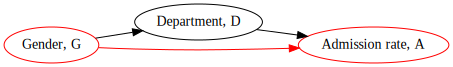

In [7]:
draw_causal_graph(
    edge_list=[
        ("G", "D"),
        ("G", "A"),
        ("D", "A")
    ],
    node_props={
        "G": {"label": "Gender, G", "color": "red"},
        "D": {"label": "Department, D"},
        "A": {"label": "Admission rate, A", "color": "red"},
    },
    edge_props={
        ("G", "A"): {"color": "red"}
    },
    graph_direction="LR"
)

- aka "Institutional discrimination"
- Referees are biased for or against a particular group
- Usually the type we're interested in identifying if it exists
- Requires strong causal assumptions

Here, deparment, D is a mediator -- this is a common structure in social sciences, where categorical status (e.g. gender) effects some mediating context (e.g. occupation), both of which affect a target outcome (wage). Examples
- wage discrimination
- hiring
- scientific awards


### Indirect Discrimination

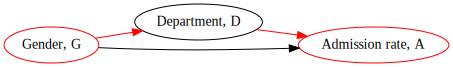

In [10]:
draw_causal_graph(
    edge_list=[
        ("G", "D"),
        ("G", "A"),
        ("D", "A")
    ],
    node_props={
        "G": {"label": "Gender, G", "color": "red"},
        "D": {"label": "Department, D"},
        "A": {"label": "Admission rate, A", "color": "red"},
    },
    edge_props={
        ("G", "D"): {"color": "red"},
        ("D", "A"): {"color": "red"}
    },
    graph_direction="LR"
)

- aka "Structural discrimination"
- e.g. Gender affects a person's interests, and therefore the department they will apply to
- Affects overall admission rates
- Requires strong causal assumptions

### Total Discrimination

In [11]:
utils.draw_causal_graph(
    edge_list=[
        ("G", "D"),
        ("G", "A"),
        ("D", "A")
    ],
    node_props={
        "G": {"label": "Gender, G", "color": "red"},
        "D": {"label": "Department, D"},
        "A": {"label": "Admission rate, A", "color": "red"},
    },
    edge_props={
        ("G", "D"): {"color": "red"},
        ("G", "A"): {"color": "red"},
        ("D", "A"): {"color": "red"}
    },
    graph_direction="LR"
)

NameError: name 'utils' is not defined

- aka "Experienced discrimination"
- through both direct and indirect routes
- Requires mild assumptions

### Estimands & Estimators
- Each of the **different estimands require a different estimators**
- Often the thing we **can estimate** often isn't what we **want to estimate**
- e.g. Total discrimination may be easier to estimate, but is less actionable

## Unobserved Confounds

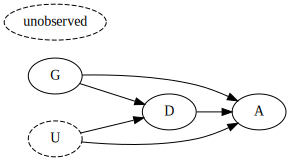

In [13]:
draw_causal_graph(
    edge_list=[
        ("G", "D"),
        ("G", "A"),
        ("D", "A"),
        ("U", "D"),
        ("U", "A")
    ],
    node_props={
        "U": {"style": "dashed"},
        "unobserved": {"style": "dashed"}
    },

    graph_direction="LR"
)

It's always possible there are also confounds between the mediator and some unobserved confounds. We will ignore these for now.

# 2. Scientific Model(s):

## Simulate the process
Below is a generative model of the review/admission process

In [8]:
np.random.seed(123)
n_samples = 1000

GENDER = stats.bernoulli.rvs(p=.5, size=n_samples)

# Groundtruth parameters
# Gender 0 tends to apply to department 0 which has a lower admission rates
P_DEPARTMENT = np.where(GENDER==0, .3, .8)

# Acceptance rates matrices -- Department x Gender Department 0 has a 10% acceptance rate and dept 1 30%
UNBIASED_ACCEPTANCE_RATES = np.array([[.1, .1], [.3, .3]])  # No *direct* gender bias

# Biased acceptance:
# - dept 0 accepts gender 0 at 50% of unbiased rate: 5%
# - dept 1 accepts gender 0 at 67% of unbiased rate: 20%
BIASED_ACCEPTANCE_RATES = np.array([[.05, .1], [.2, .3]])   # *direct* gender bias present

DEPARTMENT = stats.bernoulli.rvs(p=P_DEPARTMENT, size=n_samples).astype(int)

In [9]:
def simulate_admissions_data(bias_type):
    """Simulate admissions data using the global params above"""
    acceptance_rate = BIASED_ACCEPTANCE_RATES if bias_type == 'biased' else UNBIASED_ACCEPTANCE_RATES
    acceptance = stats.bernoulli.rvs(p=acceptance_rate[DEPARTMENT, GENDER])

    return pd.DataFrame(
        np.vstack([GENDER, DEPARTMENT, acceptance]).T,
        columns=['gender', 'department', 'accepted']
    ), acceptance_rate

for bias_type in ['unbiased', 'biased']:

    fake_admissions, acceptance_rate = simulate_admissions_data(bias_type)

    gender_acceptance_counts = fake_admissions.groupby(["gender", "accepted"]).count()['department']
    gender_acceptance_counts.name = None

    gender_department_counts = fake_admissions.groupby(["gender", "department"]).count()['accepted']
    gender_department_counts.name = None

    observed_acceptance_rates = fake_admissions.groupby("gender").mean()['accepted']
    observed_acceptance_rates.name = None

    print()
    print('-' * 30)
    print(bias_type.upper())
    print('-' * 30)
    print(f'Department Acceptance rate:\n{acceptance_rate}')
    print(f'\nGender-Department Frequency:\n{gender_department_counts}')
    print(f'\nGender-Acceptance Frequency:\n{gender_acceptance_counts}')
    print(f'\nOverall Acceptance Rates:\n{observed_acceptance_rates}')


------------------------------
UNBIASED
------------------------------
Department Acceptance rate:
[[0.1 0.1]
 [0.3 0.3]]

Gender-Department Frequency:
gender  department
0       0             335
        1             173
1       0             106
        1             386
dtype: int64

Gender-Acceptance Frequency:
gender  accepted
0       0           437
        1            71
1       0           359
        1           133
dtype: int64

Overall Acceptance Rates:
gender
0    0.139764
1    0.270325
dtype: float64

------------------------------
BIASED
------------------------------
Department Acceptance rate:
[[0.05 0.1 ]
 [0.2  0.3 ]]

Gender-Department Frequency:
gender  department
0       0             335
        1             173
1       0             106
        1             386
dtype: int64

Gender-Acceptance Frequency:
gender  accepted
0       0           465
        1            43
1       0           370
        1           122
dtype: int64

Overall Acceptance Rates:
gend

### Simulated data properties

#### Both scenarios

- Gender 0 tends to apply to department 0
- Gender 1 tends to apply to department 1

#### Unbiased scenario:
- due to lower acceptance rates in dept 0 and tendency of gender 0 to apply to dept 0, gender 0 has a lower overall rejection rate compared to gender 1
- due to higher acceptance rates in dept 1 and tendency of gender 1 to apply to dept 1, gender 1 has a higher overall acceptance rate compared to gender 0
- even in the case of no (direct) gender discrimination, **there is still indirect discrimination based on tendency of genders to apply to different departments, and the unqual likelihood that each department accepts students.**

#### Biased scenario
- overall acceptance rates are lower (due to baseline reduction in gender 0 acceptance rates across both departments)
- in the scenario where there is actual department bias, **we see a similar overall _pattern_ of discrimination as the unbiased case due to the indirect effect.**

# 3. Statistical Models

## Modeling Events
- **We observe** counts of events
- **We estimate** probabilities -- or, rather, the log-odds of events ocurring


### Linear Models
Expected value is linear (additive) combination of parameters

$$
\begin{align*}
Y_i &\sim \mathcal{N}(\mu_i, \sigma) \\
\mu_i &= \alpha + \beta_X X_i + ...
\end{align*}
$$

b.c. Normal distribution is **unbounded**, so too is the expected value of the linear model.

### Event Models
Discrete events either occur, taking the value 1, or they do not, taking the value 0. This **puts bounds** on the expected value of an event. Namely the bounds are on the interval $(0, 1)$

## Generalized Linear Models & Link Functions

- Expected value is **some function $f(\mathbb{E}[\theta])$ of an additive combination of the parameters**.

$$
f(\mathbb{E}[\theta]) = \alpha + \beta_X X_i + ...
$$

- Generally, this function $f()$, called the **link function**, will have a specific form **that is associated with the likelihood distribution**.
- the link function will have an **inverse link function** $ f^{-1}(X_i, \theta)$ such that
- to reiterate **link functions are matched to distributions**

$$
\mathbb{E}[\theta] = f^{-1}(\alpha + \beta_X X_i + ...)
$$

- In the linear regression case the likelihood model is Gaussian, and the associated link function (and inverse link function) is just the identity, $I()$. (left plot below)



In [10]:
def invlogit(x: float) -> float:
    return 1 / (1 + np.exp(-x))

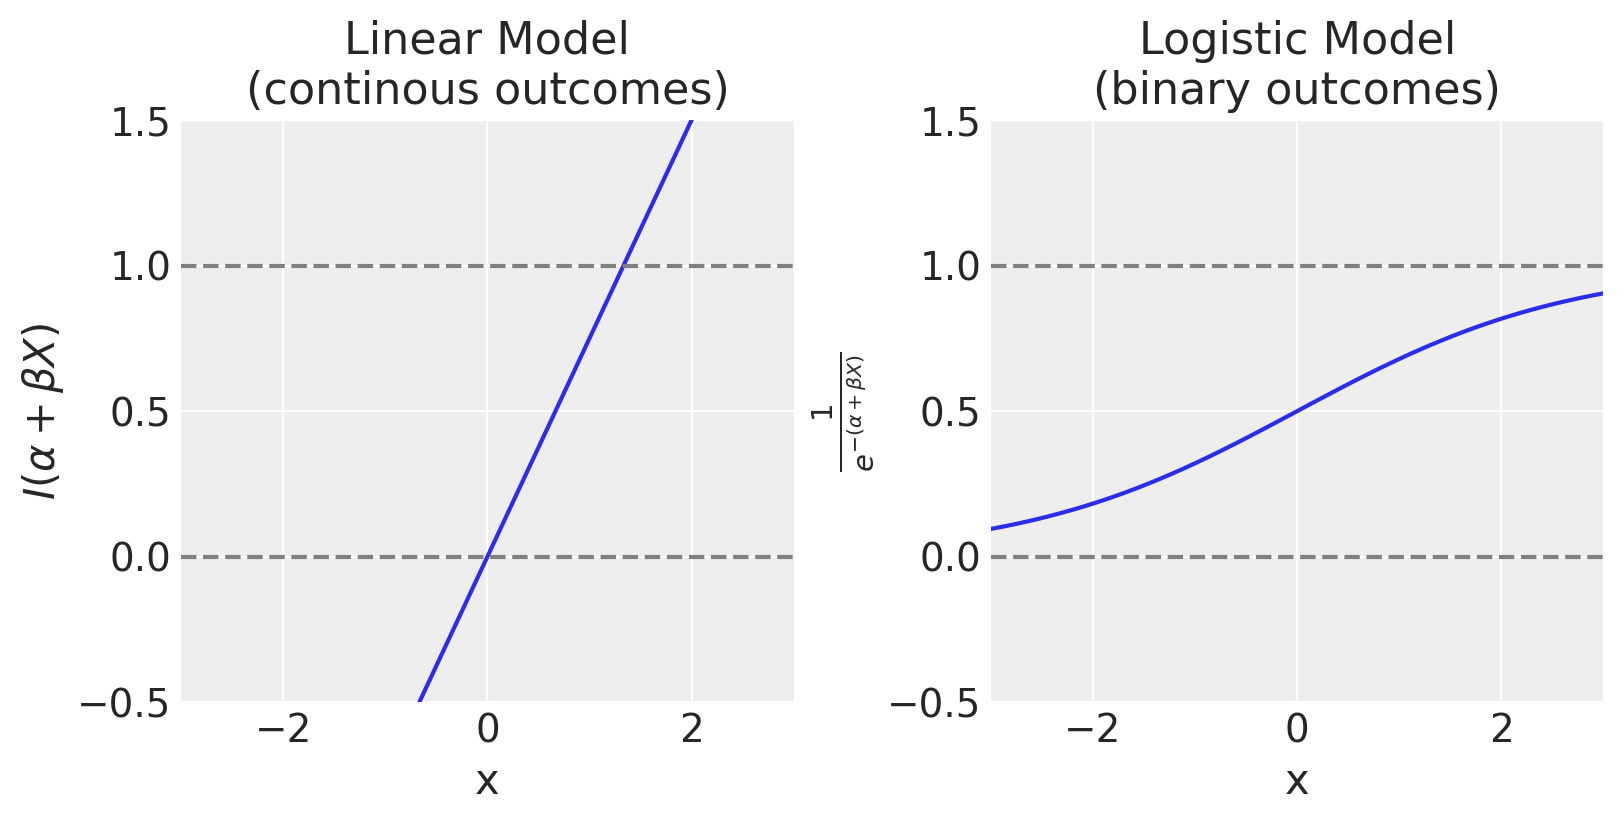

In [11]:
_, axs = plt.subplots(1, 2, figsize=(8, 4))
xs = np.linspace(-3, 3, 100)
plt.sca(axs[0])
alpha = 0
beta = .75

plt.plot(xs, alpha + beta * xs)
plt.axhline([0], linestyle='--', color='gray')
plt.axhline([1], linestyle='--', color='gray')
plt.xlim([-3, 3])
plt.ylim([-.5, 1.5])
plt.xlabel('x')
plt.ylabel('$I(\\alpha + \\beta X$)');
plt.title("Linear Model\n(continous outcomes)")

plt.sca(axs[1])
plt.plot(xs, invlogit(alpha + beta * xs))
plt.axhline([0], linestyle='--', color='gray')
plt.axhline([1], linestyle='--', color='gray')
plt.xlim([-3, 3])
plt.ylim([-.5, 1.5])
plt.xlabel('x')
plt.ylabel('$\\frac{1}{e^{-(\\alpha + \\beta X)}}$');
plt.title("Logistic Model\n(binary outcomes)");

## Logit Link Function and Logisitic Inverse function
### Binary outcomes

- **Logistic regression** used to model the probability of an event ocurring
- Likelihood function is the Bernouilli
- Associated link function is the **log-odds, or logit**: $f(p) = \frac{p}{1-p}$

$$
\begin{align*}
Y_i &\sim \text{Bernoulli}(p_i) \\
f(p_i) &= \alpha + \beta_X X_i + ...
\end{align*}
$$

- the inverse link function is the **inverse logit** aka **logistic** function (right plot above): $f^{-1}(X_i, \theta) = \frac{1}{1 + e^{-(\alpha + \beta_X X_i + ...)}}$
  - defining $\alpha + \beta_X X + ... = q$ (ignoring the data index $i$ for now), the derivation of the inverse logit is as follows
$$
\begin{align}
\log \left(\frac{p}{1-p}\right) &= \alpha + \beta_X X + ... = q \\
\frac{p}{1-p} &= e^{q} \\
p &= (1-p) e^{q} \\
p + p e^{q} &= e^{q} \\
p(1 + e^{q}) &= e^{q} \\
p &= \frac{ e^{q}}{(1 + e^{q})} \\
p &= \frac{ e^{q}}{(1 + e^{q})} \frac{e^{-q}}{e^{-q}}\\
p &= \frac{1}{(1 + e^{-q})} \\
\end{align}
$$

### logit is a harsh transform
Interpreting the log odds can be difficult at first, but in time becomes easier
- log-odds scale
- $\text{logit}(p)=0, p=0.5$
- $\text{logit}(p)=-\infty, p=0$
  - rule of thumb: $\text{logit}(p)<-4$ means event is unlikely (hardly ever)
- $\text{logit}(p)=\infty, p=1$
  - rule of thumb: $\text{logit}(p)>4$ means event is very likely (nearly always)

In [12]:
def plot_line(xs, ys, **plot_kwargs):
    """Plot line with consistent style (e.g. bordered lines)"""
    linewidth = plot_kwargs.get("linewidth", 3)
    plot_kwargs["linewidth"] = linewidth

    # Copy settings for background
    background_plot_kwargs = {k: v for k, v in plot_kwargs.items()}
    background_plot_kwargs["linewidth"] = linewidth + 2
    background_plot_kwargs["color"] = "white"
    del background_plot_kwargs["label"]  # no legend label for background

    plt.plot(xs, ys, **background_plot_kwargs, zorder=30)
    plt.plot(xs, ys, **plot_kwargs, zorder=31)

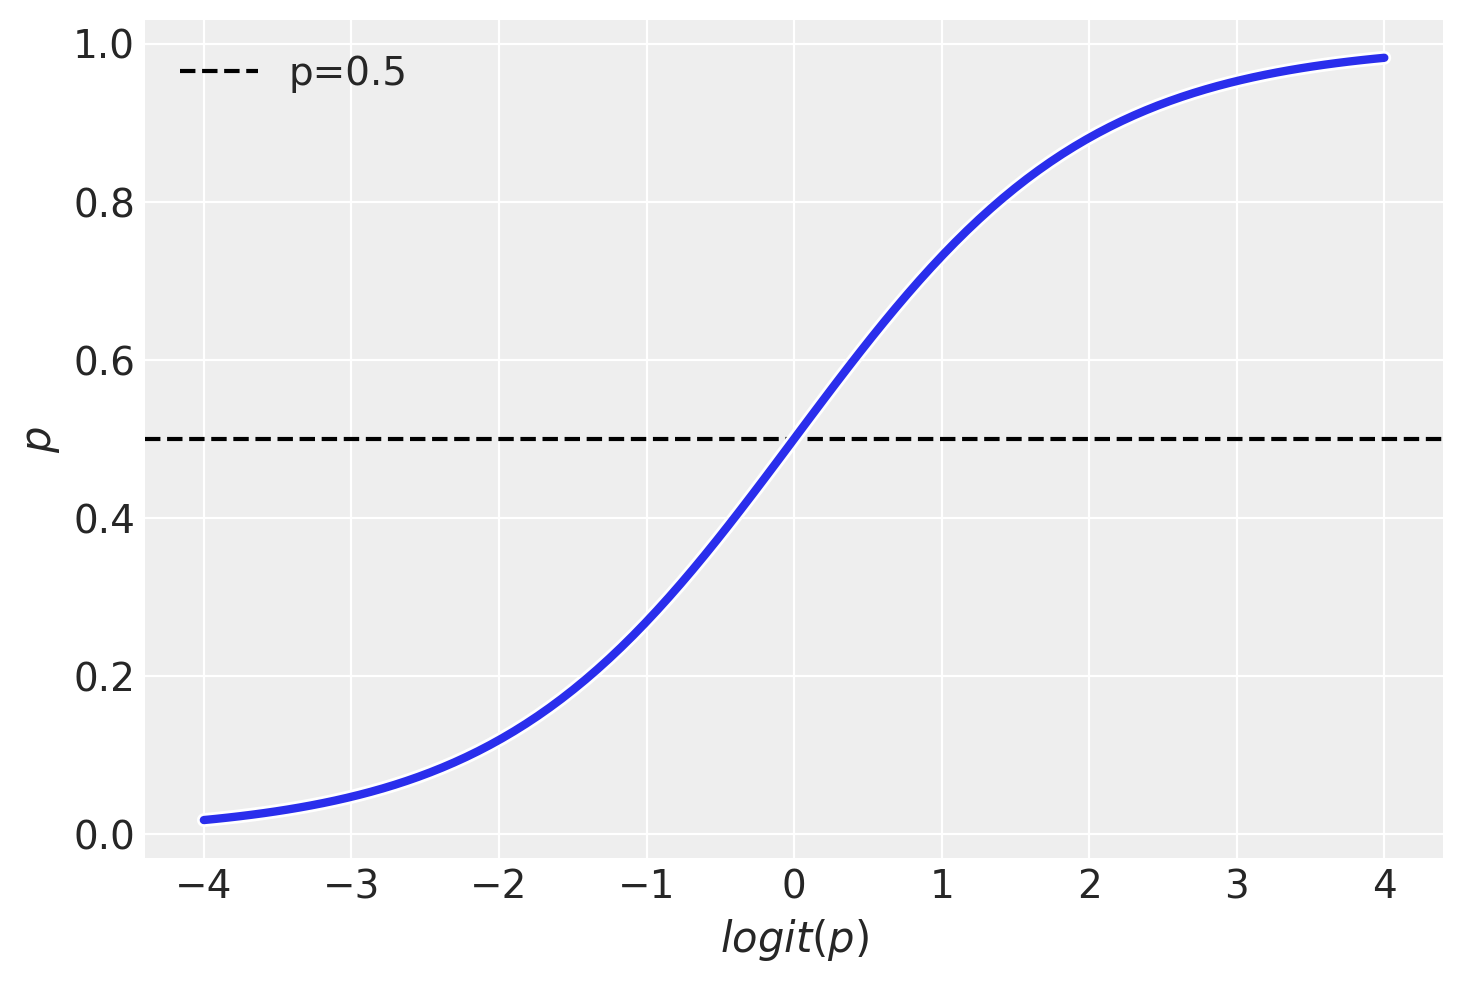

In [14]:
log_odds = np.linspace(-4, 4, 100)
plot_line(log_odds, invlogit(log_odds), label=None)
plt.axhline(0.5, linestyle="--", color='k', label="p=0.5")
plt.xlabel("$logit(p)$")
plt.ylabel("$p$")
plt.legend();

### Bayesian Updating for Logistic Regression
For the following simulation, we'll use a custom utility function `utils.simulate_2_parameter_bayesian_learning` for simulating general Bayeisan posterior update simulation. Here's the API for that function (for more details see `utils.py`)

In [15]:
def simulate_2_parameter_bayesian_learning(
    x_obs,
    y_obs,
    param_a_grid,
    param_b_grid,
    true_param_a,
    true_param_b,
    model_func,
    posterior_func,
    n_posterior_samples=3,
    param_labels=None,
    data_range_x=None,
    data_range_y=None,
):
    """General function for simulating Bayesian learning in a 2-parameter model
    using grid approximation.

    Parameters
    ----------
    x_obs : np.ndarray
        The observed x values
    y_obs : np.ndarray
        The observed y values
    param_a_grid: np.ndarray
        The range of values the first model parameter in the model can take.
        Note: should have same length as param_b_grid.
    param_b_grid: np.ndarray
        The range of values the second model parameter in the model can take.
        Note: should have same length as param_a_grid.
    true_param_a: float
        The true value of the first model parameter, used for visualizing ground
        truth
    true_param_b: float
        The true value of the second model parameter, used for visualizing ground
        truth
    model_func: Callable
        A function `f` of the form `f(x, param_a, param_b)`. Evaluates the model
        given at data points x, given the current state of parameters, `param_a`
        and `param_b`. Returns a scalar output for the `y` associated with input
        `x`.
    posterior_func: Callable
        A function `f` of the form `f(x_obs, y_obs, param_grid_a, param_grid_b)
        that returns the posterior probability given the observed data and the
        range of parameters defined by `param_grid_a` and `param_grid_b`.
    n_posterior_samples: int
        The number of model functions sampled from the 2D posterior
    param_labels: Optional[list[str, str]]
        For visualization, the names of `param_a` and `param_b`, respectively
    data_range_x: Optional len-2 float sequence
        For visualization, the upper and lower bounds of the domain used for model
        evaluation
    data_range_y: Optional len-2 float sequence
        For visualization, the upper and lower bounds of the range used for model
        evaluation.
    """
    param_labels = param_labels if param_labels is not None else ["param_a", "param_b"]
    data_range_x = (x_obs.min(), x_obs.max()) if data_range_x is None else data_range_x
    data_range_y = (y_obs.min(), y_obs.max()) if data_range_y is None else data_range_y

    # NOTE: assume square parameter grid
    resolution = len(param_a_grid)

    param_a_grid, param_b_grid = np.meshgrid(param_a_grid, param_b_grid)
    param_a_grid = param_a_grid.ravel()
    param_b_grid = param_b_grid.ravel()

    posterior = posterior_func(x_obs, y_obs, param_a_grid, param_b_grid)

    # Visualization
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot Posterior over intercept and slope params
    plt.sca(axs[0])
    plt.contour(
        param_a_grid.reshape(resolution, resolution),
        param_b_grid.reshape(resolution, resolution),
        posterior.reshape(resolution, resolution),
        cmap="gray_r",
    )

    # Sample locations in parameter space according to posterior
    sample_idx = np.random.choice(
        np.arange(len(posterior)),
        p=posterior / posterior.sum(),
        size=n_posterior_samples,
    )

    param_a_list = []
    param_b_list = []
    for ii, idx in enumerate(sample_idx):
        param_a = param_a_grid[idx]
        param_b = param_b_grid[idx]
        param_a_list.append(param_a)
        param_b_list.append(param_b)

        # Add sampled parameters to posterior
        plt.scatter(param_a, param_b, s=60, c=f"C{ii}", alpha=0.75, zorder=20)

    # Add the true params to the plot for reference
    plt.scatter(
        true_param_a, true_param_b, color="k", marker="x", s=60, label="true parameters"
    )

    plt.xlabel(param_labels[0])
    plt.ylabel(param_labels[1])

    # Plot the current training data and model trends sampled from posterior
    plt.sca(axs[1])
    plt.scatter(x_obs, y_obs, s=60, c="k", alpha=0.5)

    # Plot the resulting model functions sampled from posterior
    xs = np.linspace(data_range_x[0], data_range_x[1], 100)
    for ii, (param_a, param_b) in enumerate(zip(param_a_list, param_b_list)):
        ys = model_func(xs, param_a, param_b)
        plt.plot(xs, ys, color=f"C{ii}", linewidth=4, alpha=0.5)

    groundtruth_ys = model_func(xs, true_param_a, true_param_b)
    plt.plot(
        xs, groundtruth_ys, color="k", linestyle="--", alpha=0.5, label="true trend"
    )

    plt.xlim([data_range_x[0], data_range_x[1]])
    plt.xlabel("x value")

    plt.ylim([data_range_y[0], data_range_y[1]])
    plt.ylabel("y value")

    plt.title(f"N={len(y_obs)}")
    plt.legend(loc="upper left")

In [16]:
help(simulate_2_parameter_bayesian_learning)

Help on function simulate_2_parameter_bayesian_learning in module __main__:

simulate_2_parameter_bayesian_learning(x_obs, y_obs, param_a_grid, param_b_grid, true_param_a, true_param_b, model_func, posterior_func, n_posterior_samples=3, param_labels=None, data_range_x=None, data_range_y=None)
    General function for simulating Bayesian learning in a 2-parameter model
    using grid approximation.
    
    Parameters
    ----------
    x_obs : np.ndarray
        The observed x values
    y_obs : np.ndarray
        The observed y values
    param_a_grid: np.ndarray
        The range of values the first model parameter in the model can take.
        Note: should have same length as param_b_grid.
    param_b_grid: np.ndarray
        The range of values the second model parameter in the model can take.
        Note: should have same length as param_a_grid.
    true_param_a: float
        The true value of the first model parameter, used for visualizing ground
        truth
    true_param_b

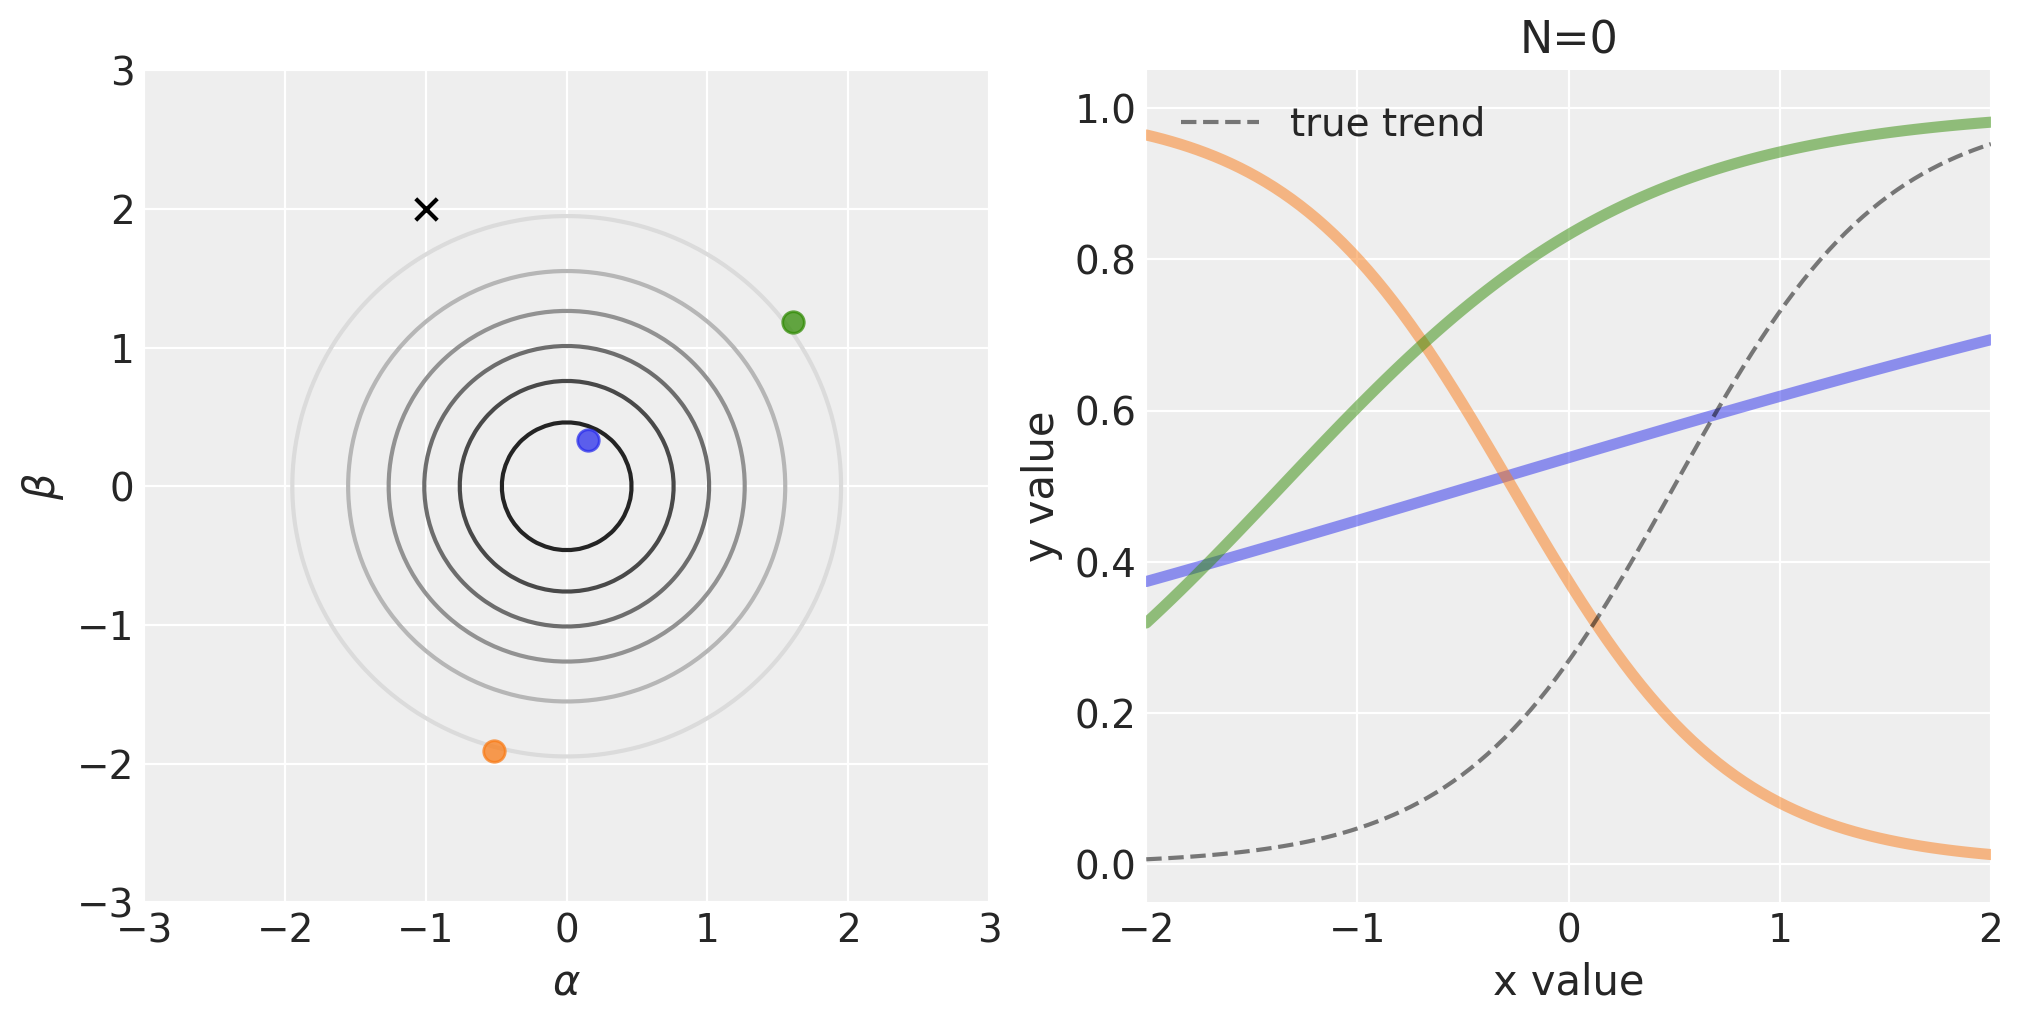

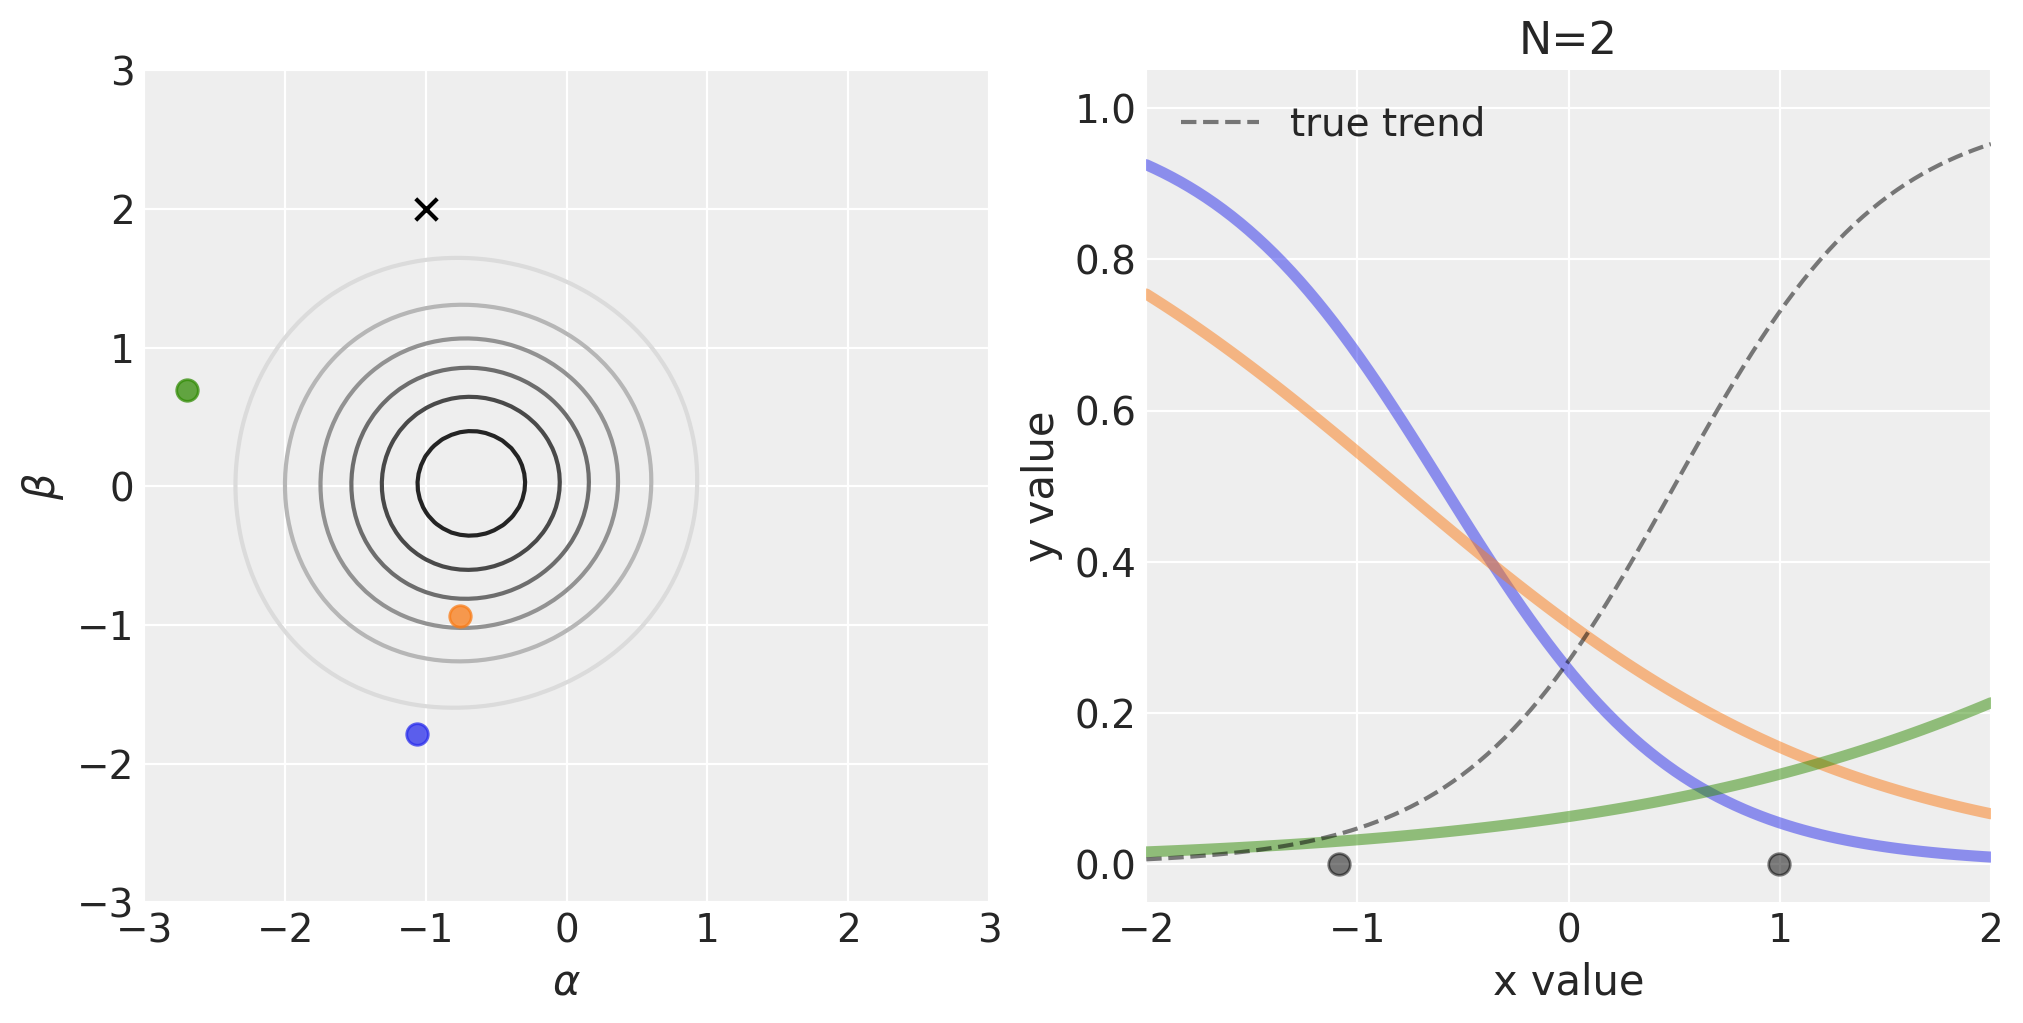

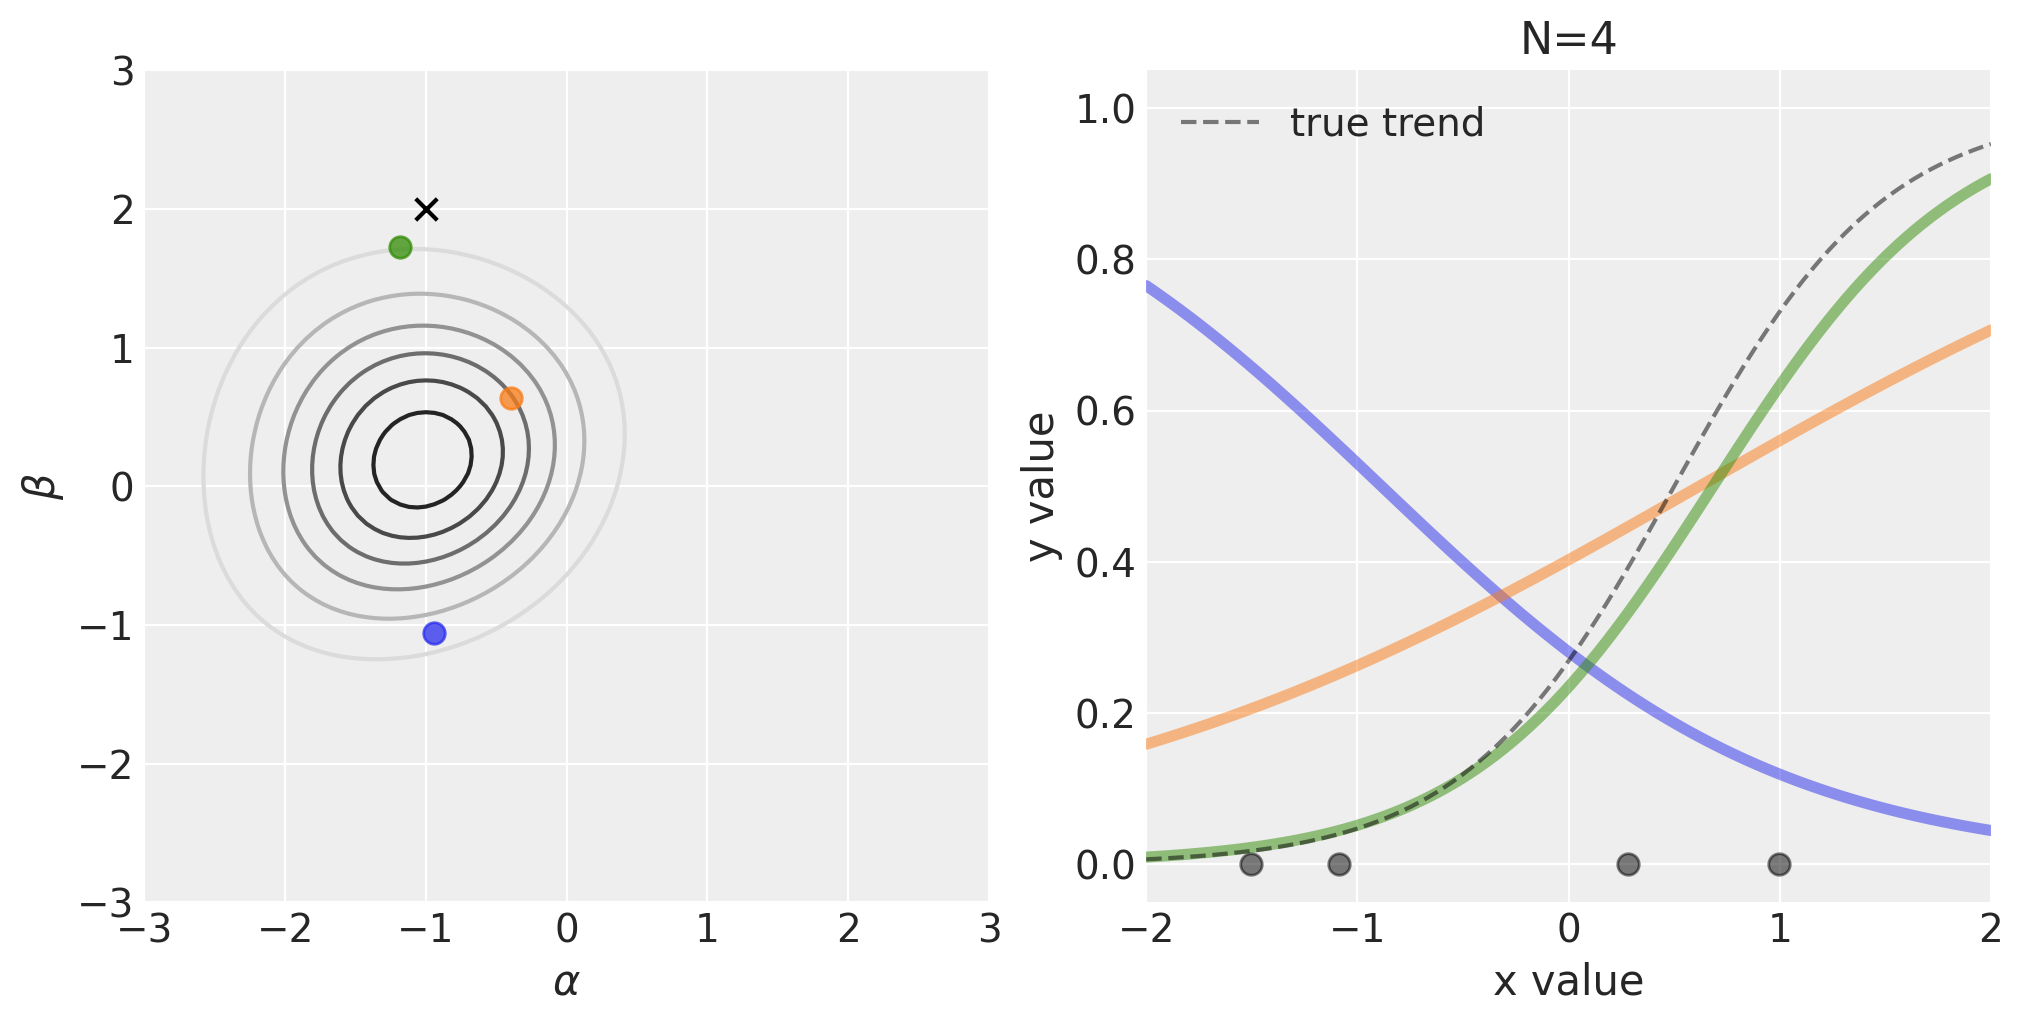

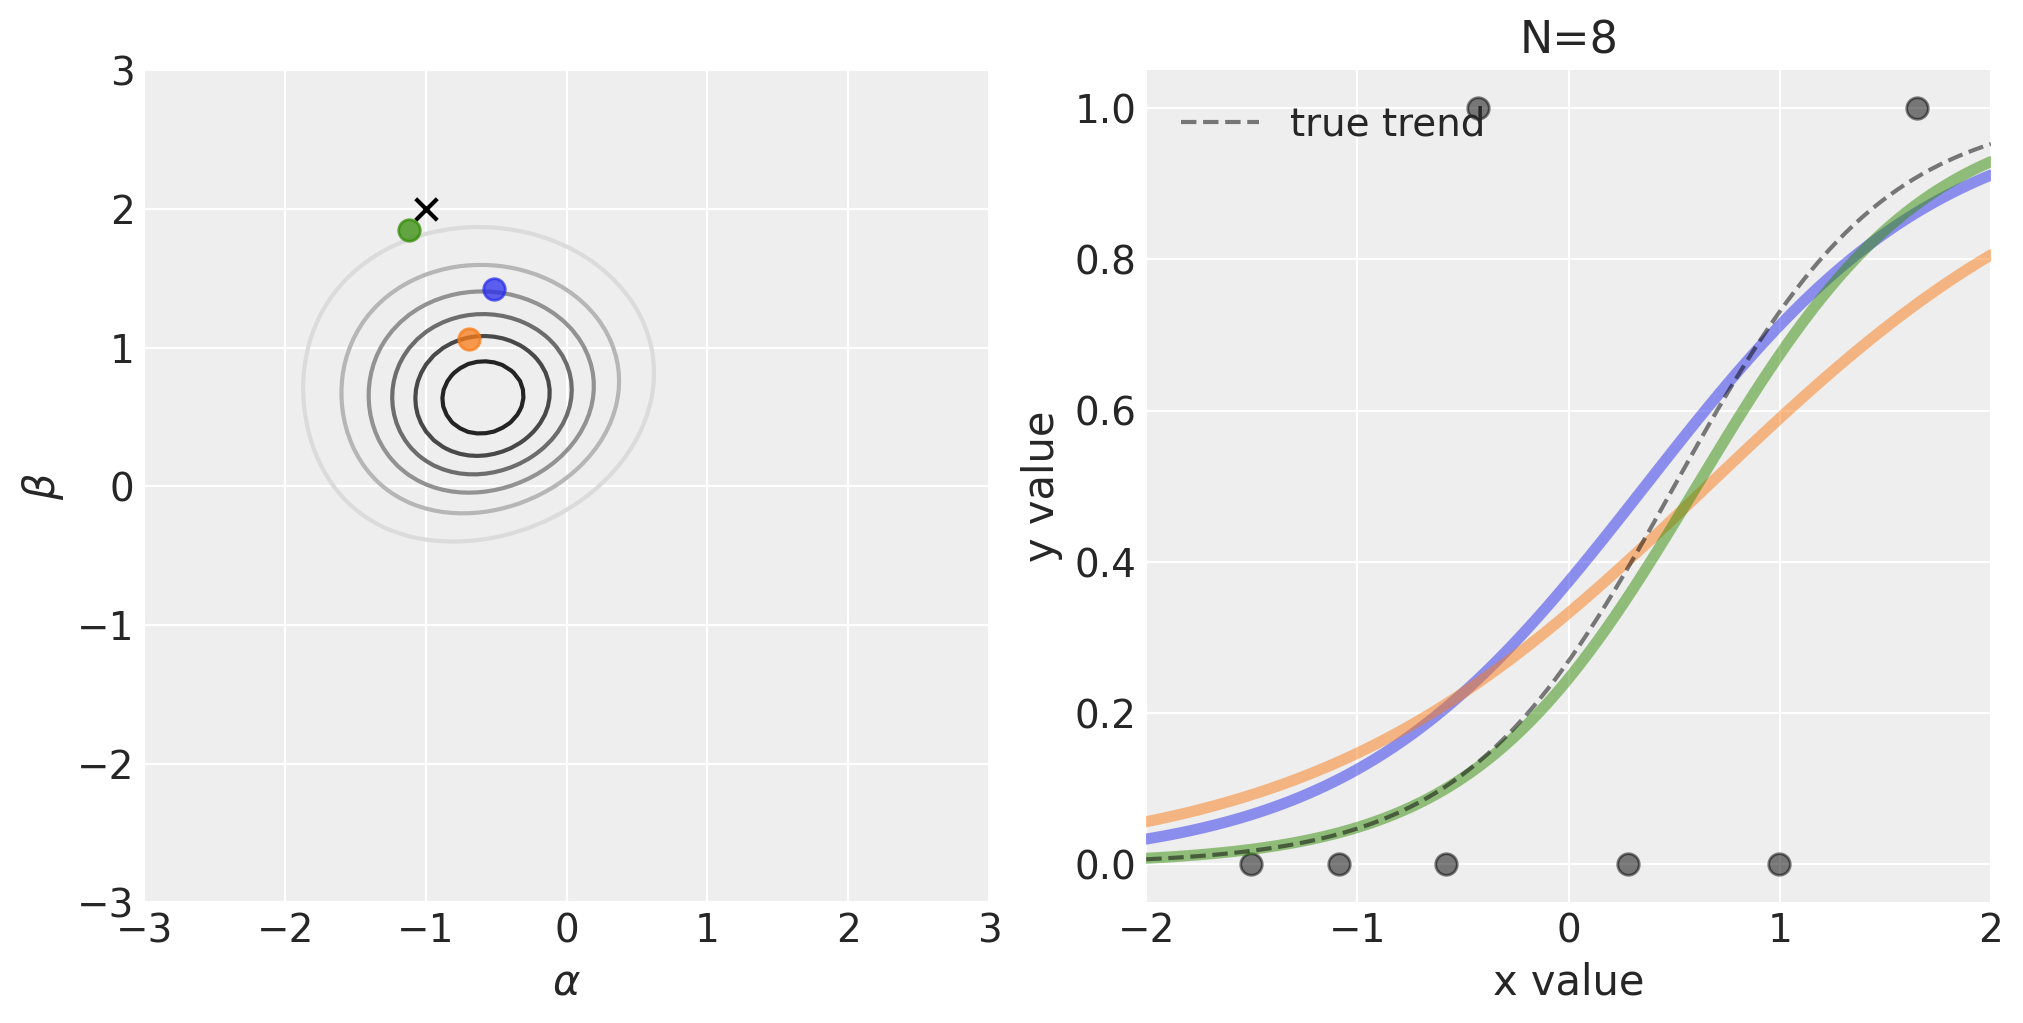

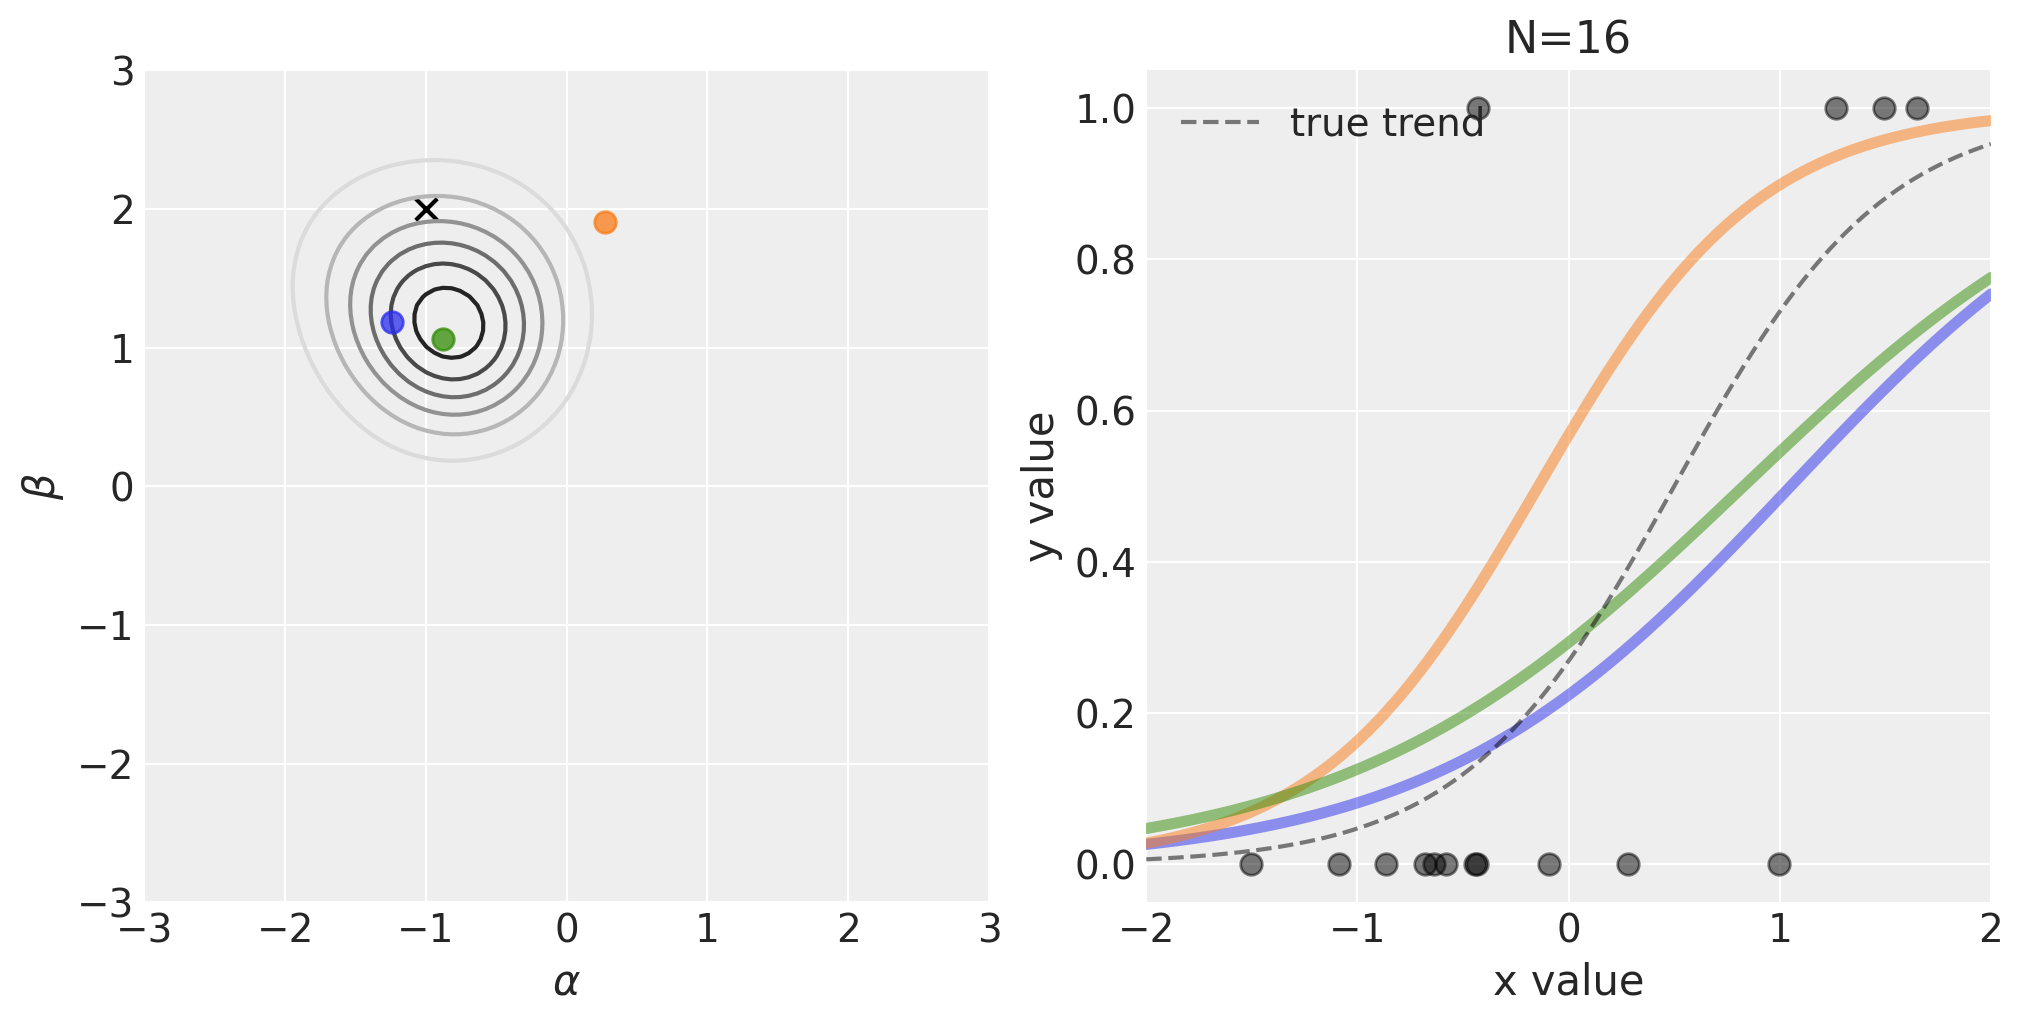

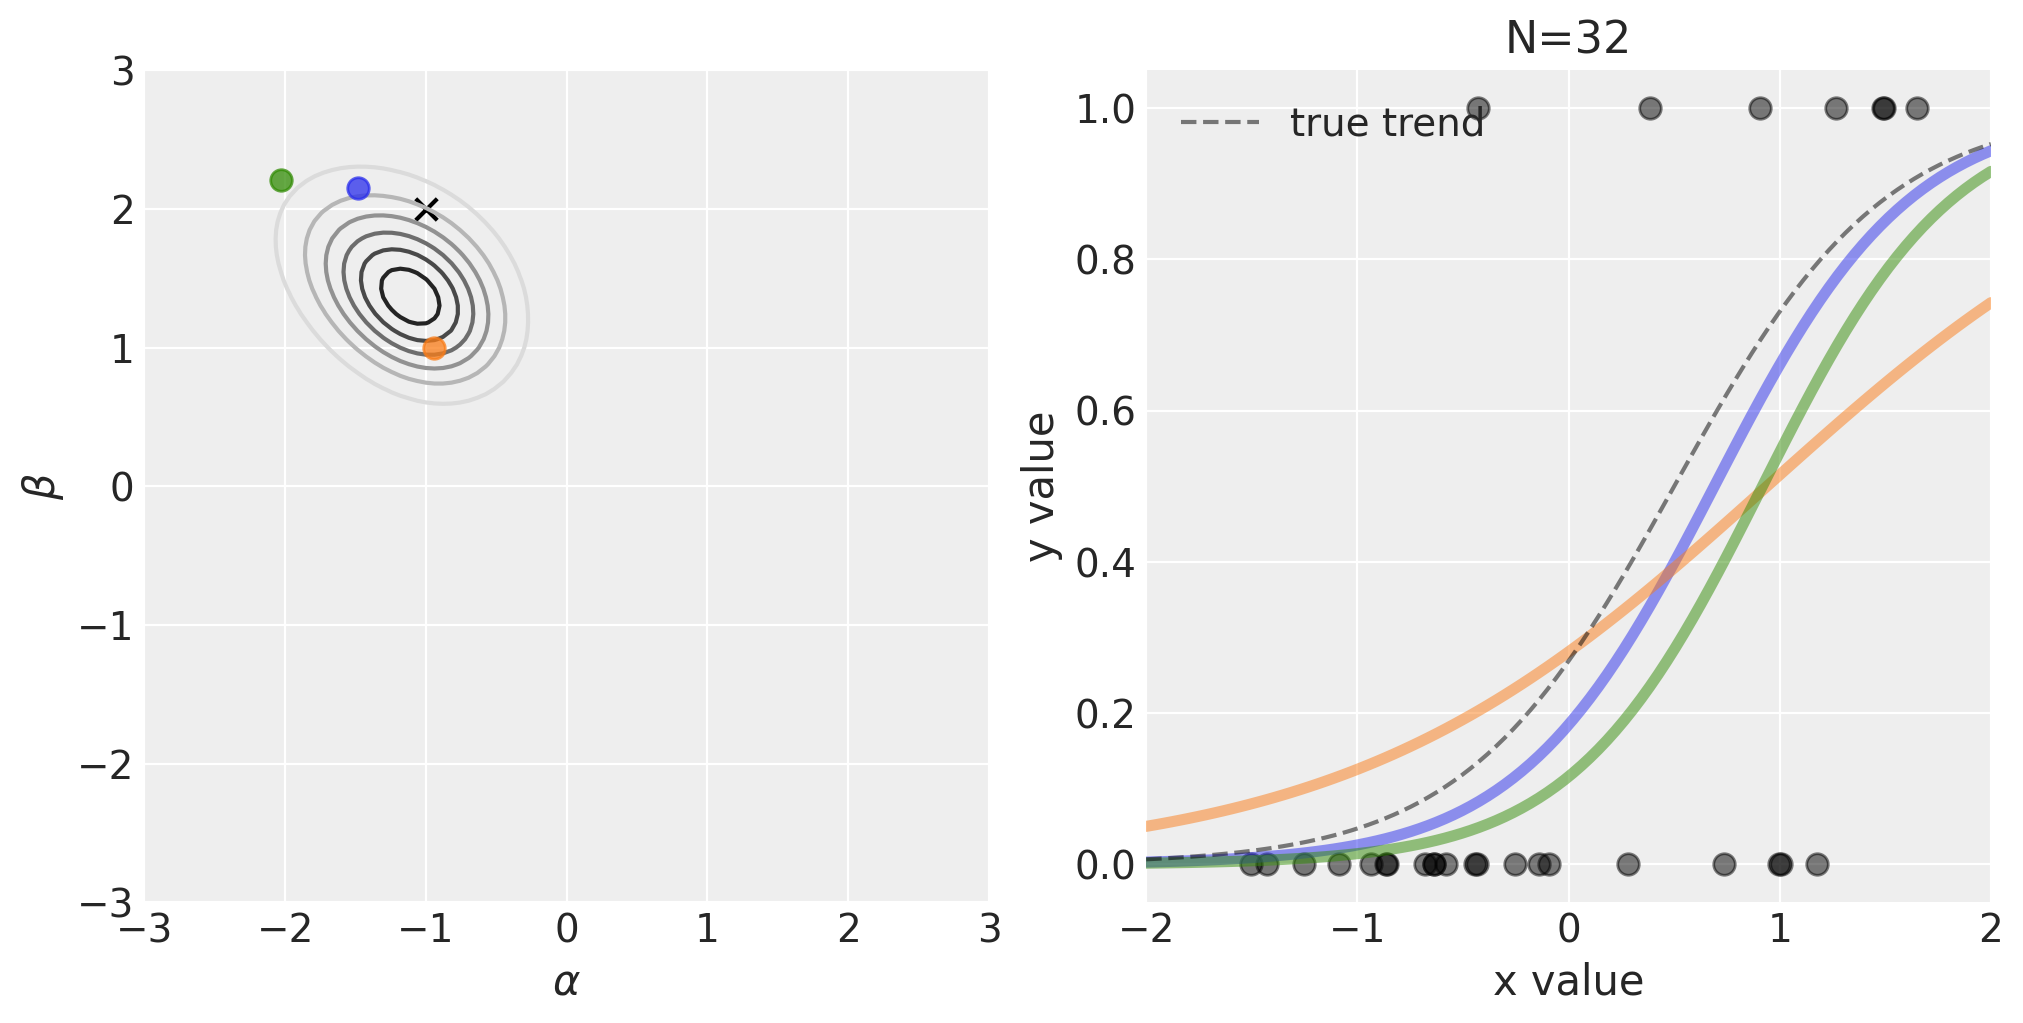

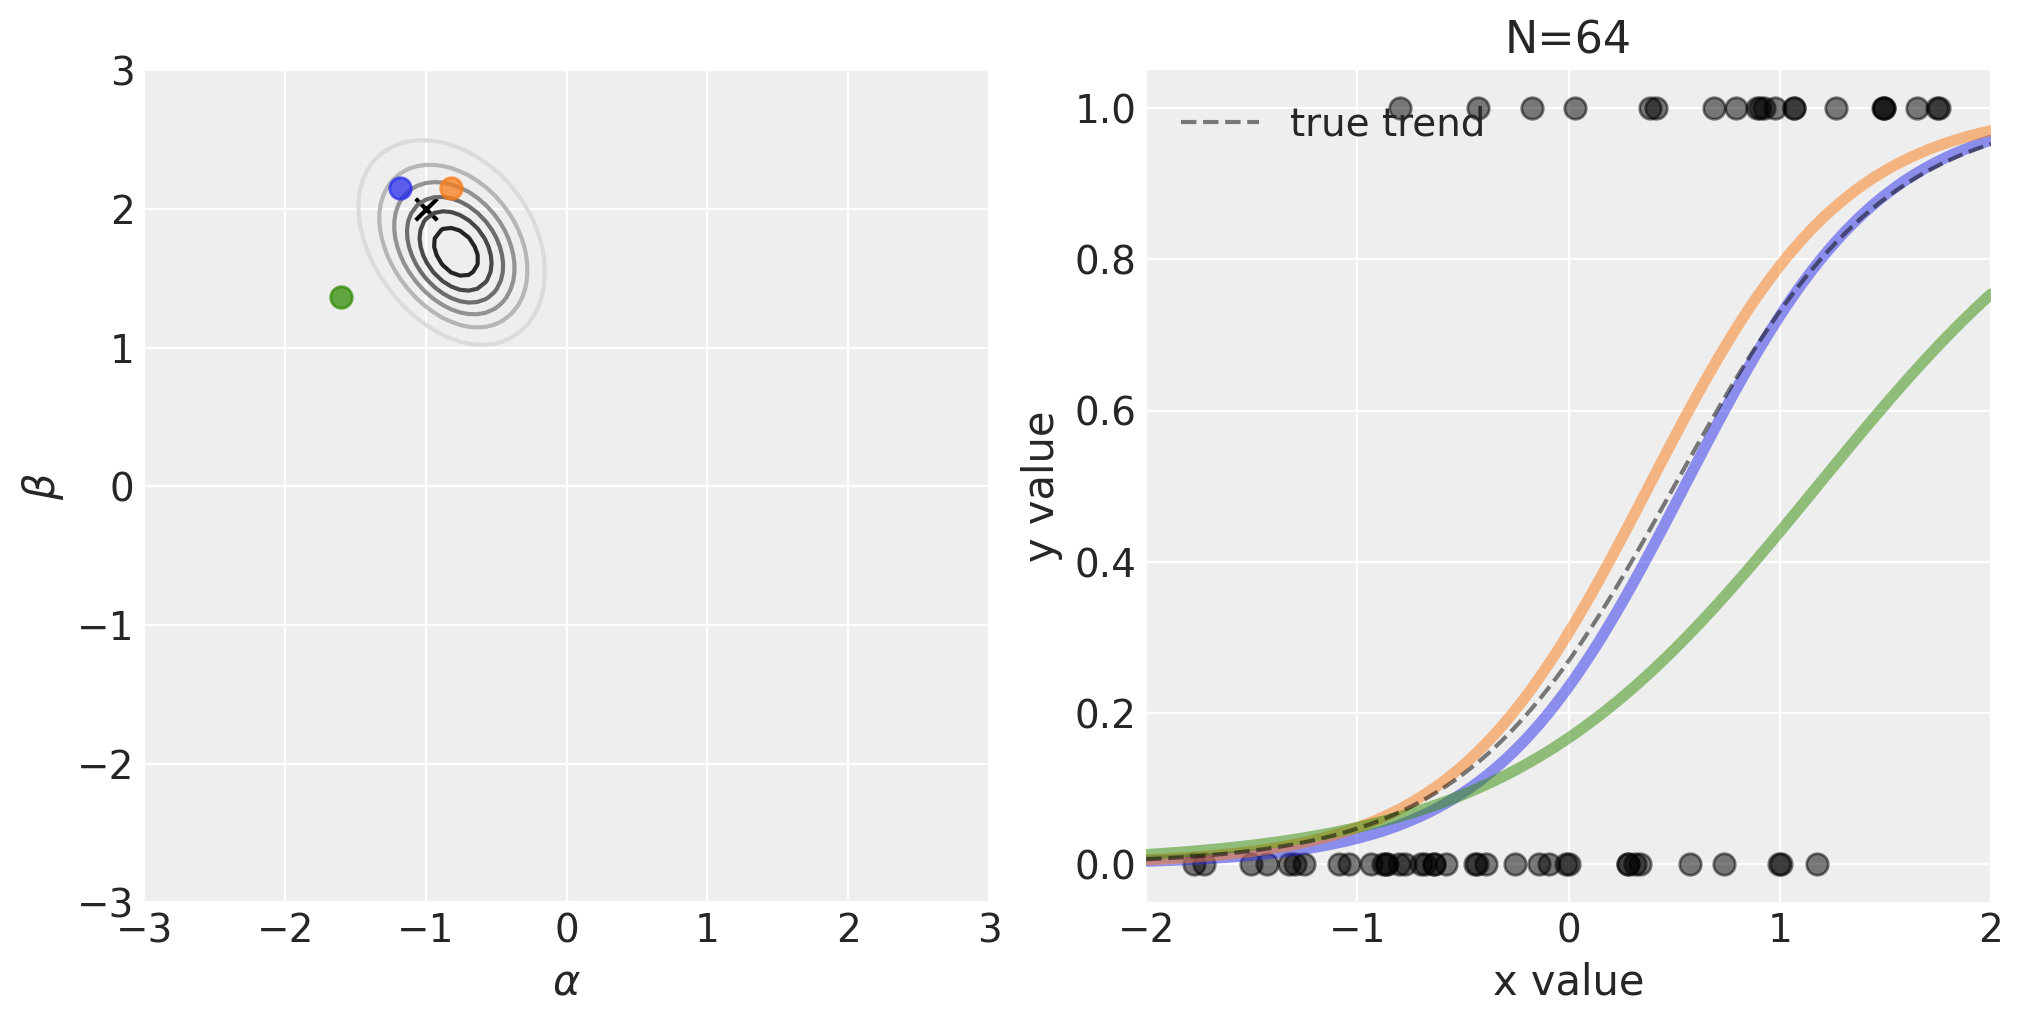

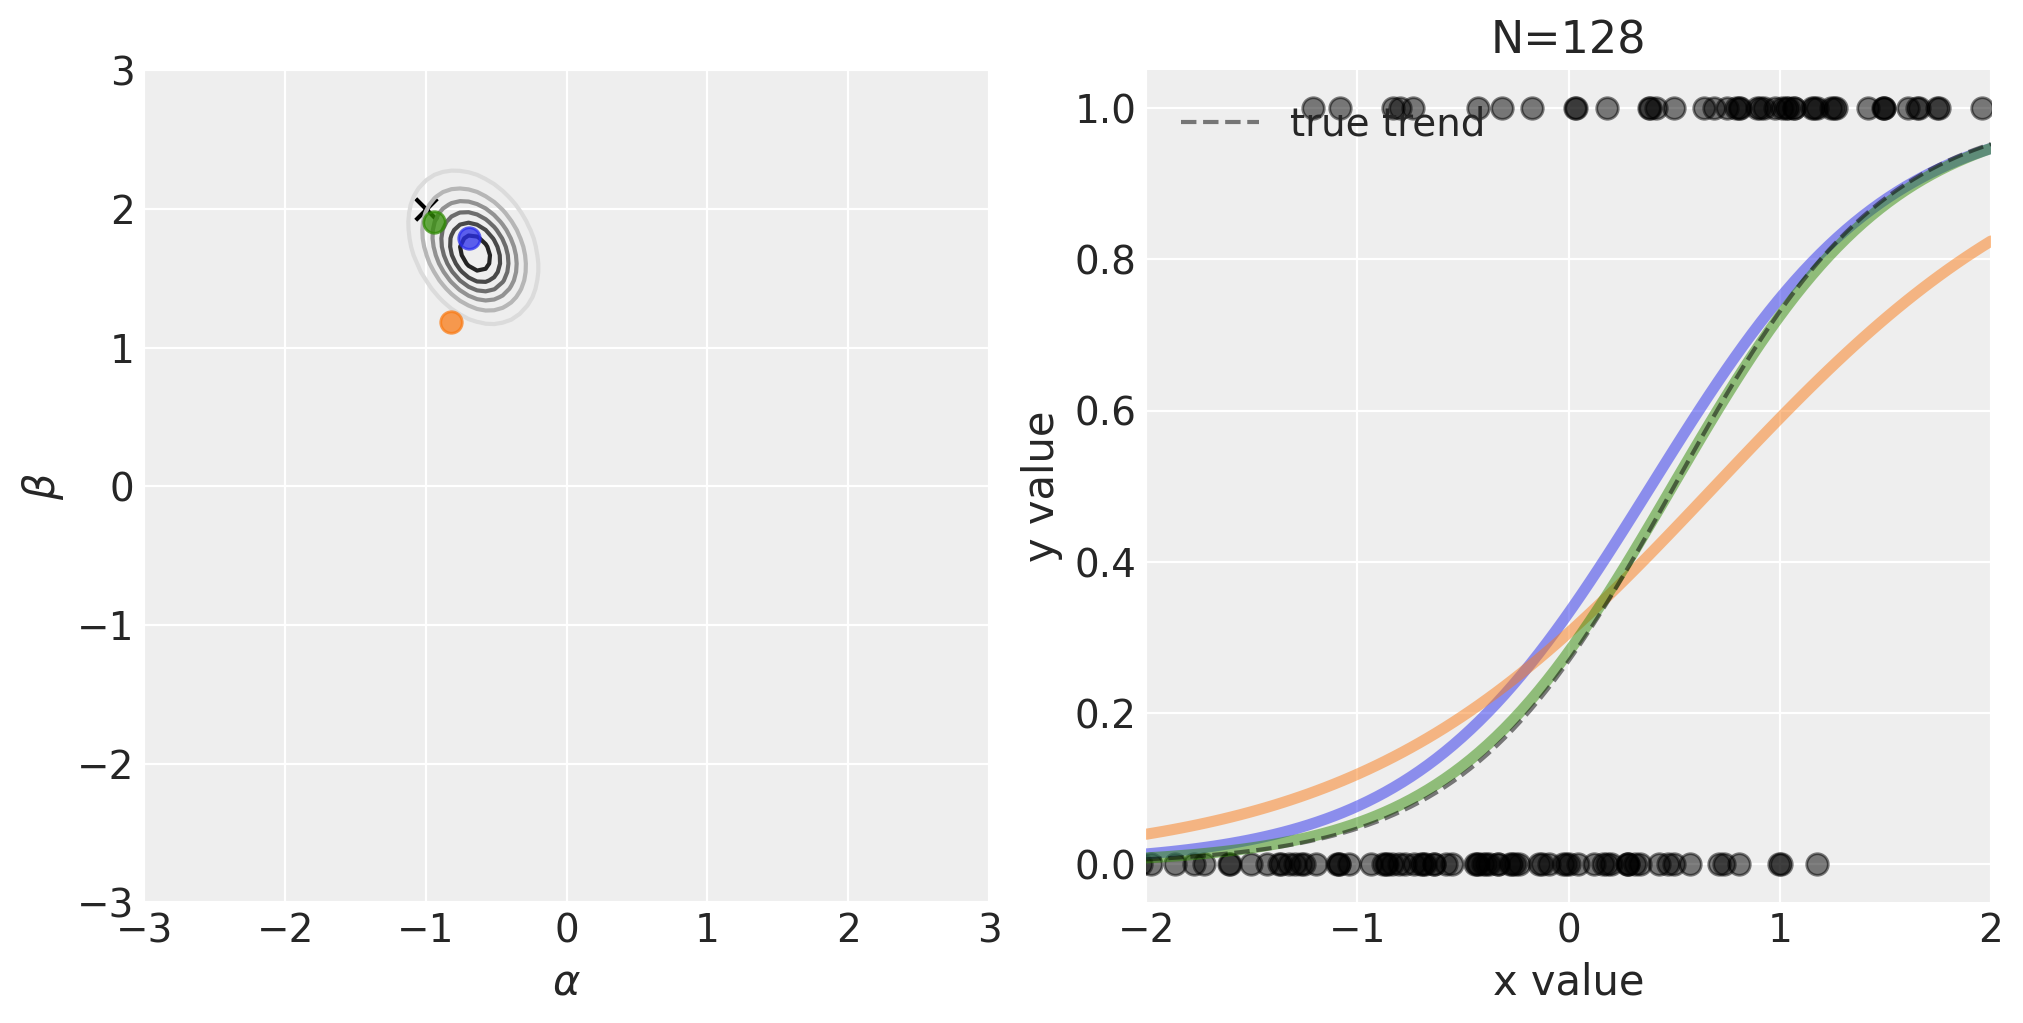

In [17]:
# Model function required for simulation
def logistic_model(x, alpha, beta):
    return invlogit(alpha + beta * x)

# Posterior function required for simulation
def logistic_regression_posterior(x_obs, y_obs, alpha_grid, beta_grid, likelihood_prior_std = .01):

    # Convert params to 1-d arrays
    if np.ndim(alpha_grid) > 1:
        alpha_grid = alpha_grid.ravel()

    if np.ndim(beta_grid):
        beta_grid = beta_grid.ravel()

    log_prior_intercept = stats.norm(0, 1).logpdf(alpha_grid)
    log_prior_slope = stats.norm(0, 1).logpdf(beta_grid)

    log_likelihood = np.array(
        [
            stats.bernoulli(
                p=invlogit(a + b * x_obs)
            ).logpmf(y_obs) for a, b in zip(alpha_grid, beta_grid)
        ]
    ).sum(axis=1)

    # Posterior is equal to the product of likelihood and priors (here a sum in log scale)
    log_posterior = log_likelihood + log_prior_intercept + log_prior_slope

    # Convert back to natural scale
    return np.exp(log_posterior - log_posterior.max())

# Generate data for demo
np.random.seed(123)
RESOLUTION = 100
N_DATA_POINTS = 128

# Ground truth parameters
ALPHA = -1
BETA = 2

x = stats.norm(0, 1).rvs(size=N_DATA_POINTS)
p_y = invlogit(ALPHA + BETA * x)
y = stats.bernoulli.rvs(p=p_y)

alpha_grid = np.linspace(-3, 3, RESOLUTION)
beta_grid = np.linspace(-3, 3, RESOLUTION)

# Vary the sample size to show how the posterior adapts to more and more data
for n_samples in [0, 2, 4, 8, 16, 32, 64, 128]:
    # Run the simulation
    simulate_2_parameter_bayesian_learning(
        x_obs=x[:n_samples],
        y_obs=y[:n_samples],
        param_a_grid=alpha_grid,
        param_b_grid=beta_grid,
        true_param_a=ALPHA,
        true_param_b=BETA,
        model_func=logistic_model,
        posterior_func=logistic_regression_posterior,
        param_labels=['$\\alpha$', '$\\beta$'],
        data_range_x=(-2, 2), data_range_y=(-.05, 1.05)
    )

## Priors for logistic regression

**logit link function is a harsh transform**
- Logit compresses parameter distributions
- $x > +4 \rightarrow $ event basically always occurs
- $x < -4 \rightarrow$ event basically never occurs

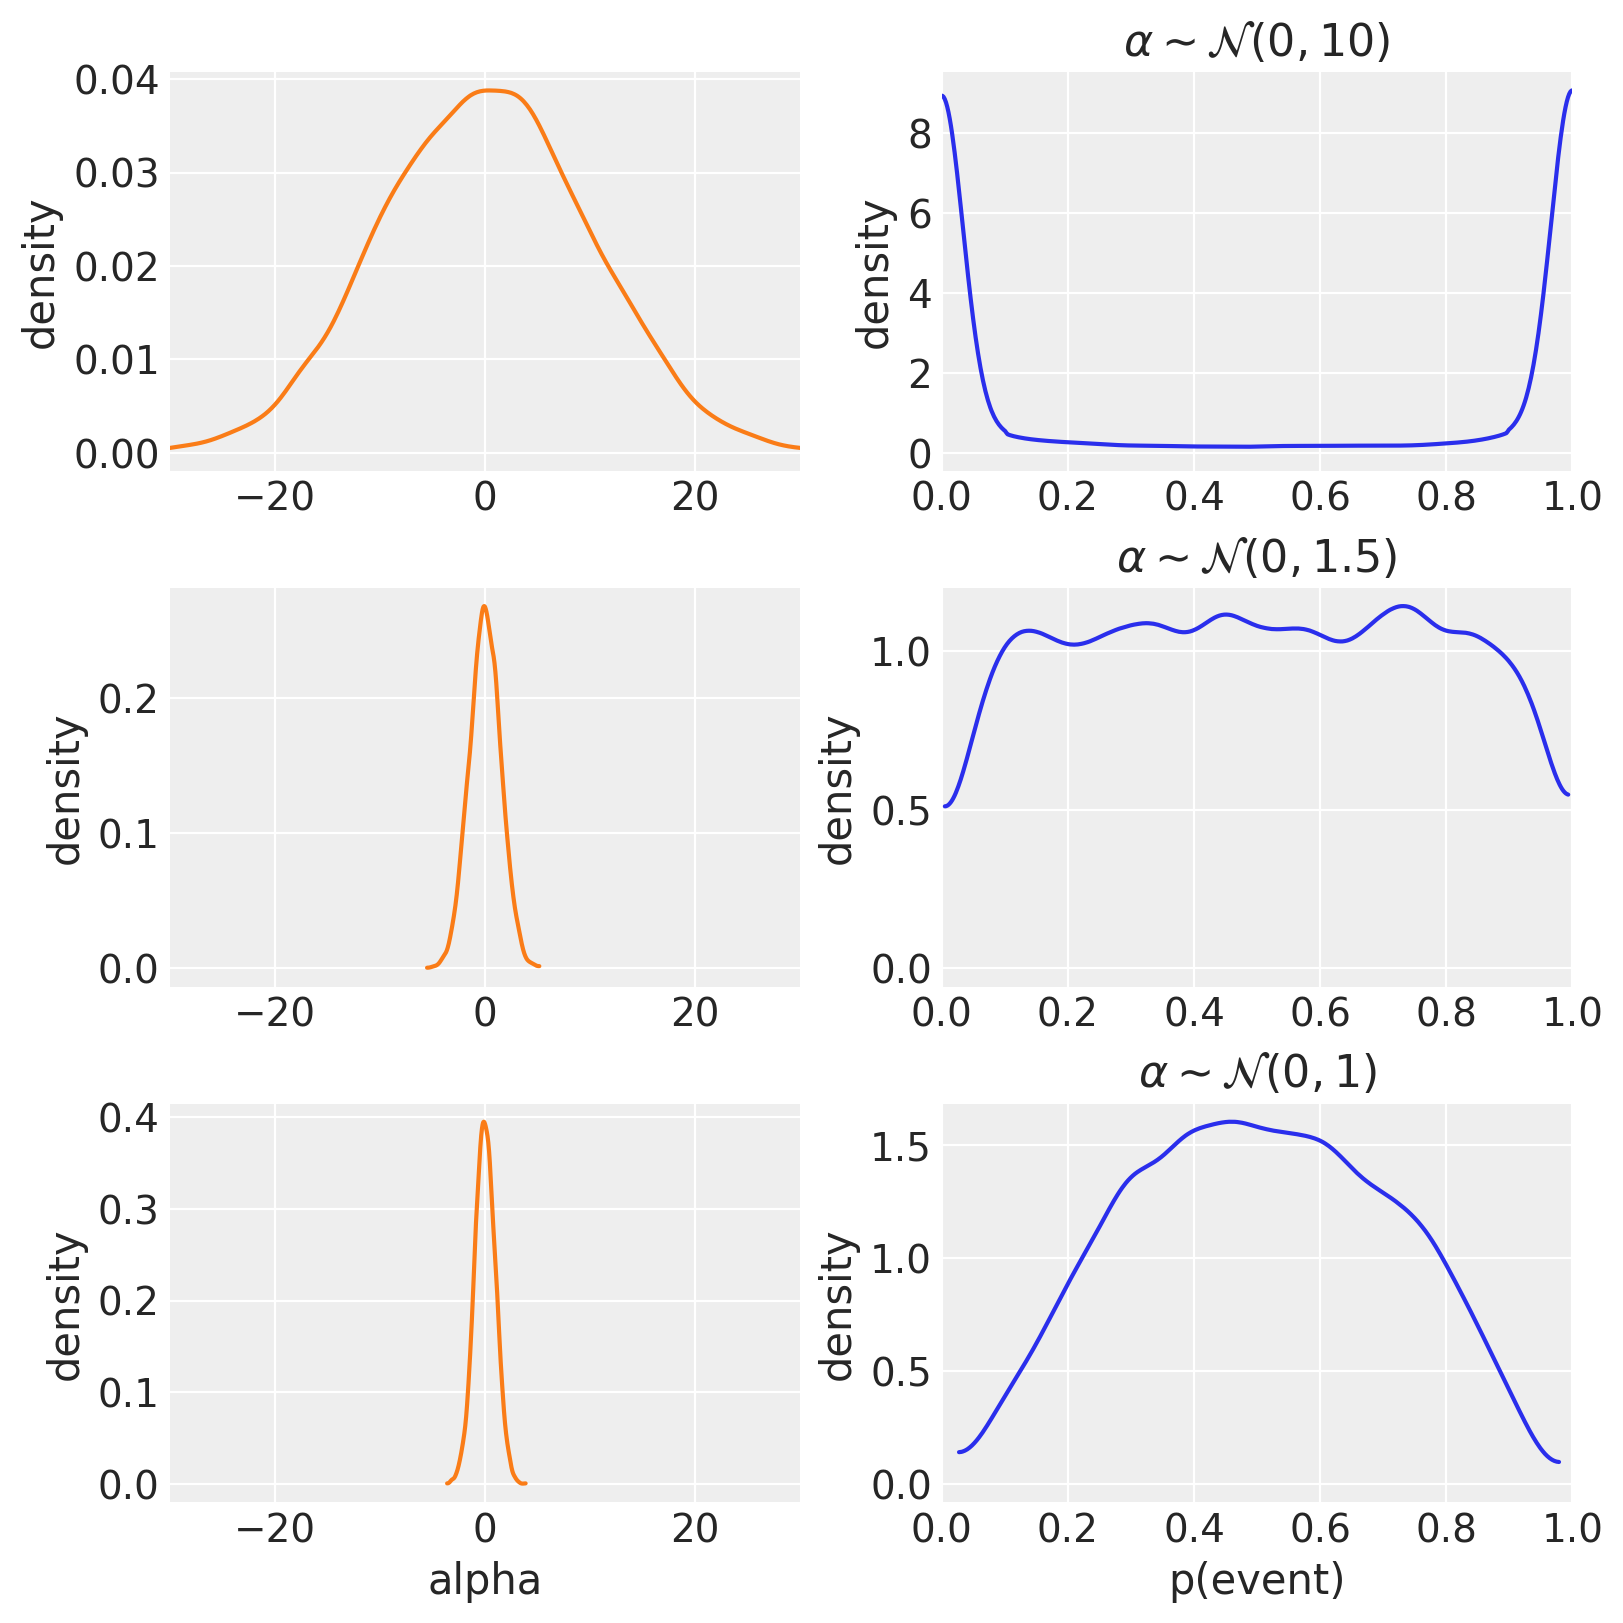

In [19]:
n_samples = 10000
fig, axs = plt.subplots(3, 2, figsize=(8, 8))
for ii, std in enumerate([10, 1.5, 1]):

    # Alpha prior distribution
    alphas = stats.norm(0, std).rvs(n_samples)
    plt.sca(axs[ii][0])
    az.plot_dist(alphas, color='C1')
    plt.xlim([-30, 30])
    plt.ylabel('density')
    if ii == 2:
        plt.xlabel("alpha")

    # Resulting event probability distribution
    ps = invlogit(alphas)
    plt.sca(axs[ii][1])
    az.plot_dist(ps, color="C0")
    plt.xlim([0, 1])
    plt.ylabel('density')
    plt.title(f"$\\alpha \sim \mathcal{{N}}(0, {std})$")
    if ii == 2:
        plt.xlabel("p(event)")


### Prior Predictive Simulations

In [20]:
# Demonstrating the effect of alpha / beta on p(x)
from functools import partial

def gaussian_2d_pdf(xs, ys, mean=(0, 0), covariance=np.eye(2)):
    return np.array(stats.multivariate_normal(mean, covariance).pdf(np.vstack([xs, ys]).T))

pdf = partial(gaussian_2d_pdf)

xs =  ys = np.linspace(-3, 3, 100)
# utils.plot_2d_function(xs, ys, pdf, cmap='gray_r')

def plot_logistic_prior_predictive(n_samples = 20, prior_std=.5):

    _, axs = plt.subplots(1, 2, figsize=(10, 4))
    plt.sca(axs[0])
    min_x, max_x = -prior_std, prior_std
    xs = np.linspace(min_x, max_x, 100)
    ys = xs

    pdf = partial(gaussian_2d_pdf, covariance=np.array([[prior_std ** 2, 0],[0, prior_std ** 2]]))
    plot_2d_function(xs, ys, pdf, cmap='gray_r')

    plt.axis("square")
    plt.xlim([min_x, max_x])
    plt.ylim([min_x, max_x])

    # Sample some parameters from prior
    βs = stats.norm.rvs(0, prior_std, size=n_samples)
    αs = stats.norm.rvs(0, prior_std, size=n_samples)

    for b, a in zip(βs, αs):
        plt.scatter(a, b)

    plt.xlabel("$\\alpha$")
    plt.ylabel("$\\beta$")
    plt.title(f"Samples from prior with std={prior_std}")

    # Resulting sigmoid functions
    plt.sca(axs[1])
    min_x, max_x = -3, 3
    xs = np.linspace(min_x, max_x, 100)
    for a, b in zip(αs, βs):
        logit_p = a + xs * b
        p = invlogit(logit_p)
        plt.plot(xs, p)

    plt.xlabel('x')
    plt.ylabel('p = invlogit(x)')
    plt.xlim([-3, 3])
    plt.ylim([-.05, 1.05]);
    plt.axhline(0.5, linestyle='--', color='k')
    plt.title(f"Resulting Logistic Models")

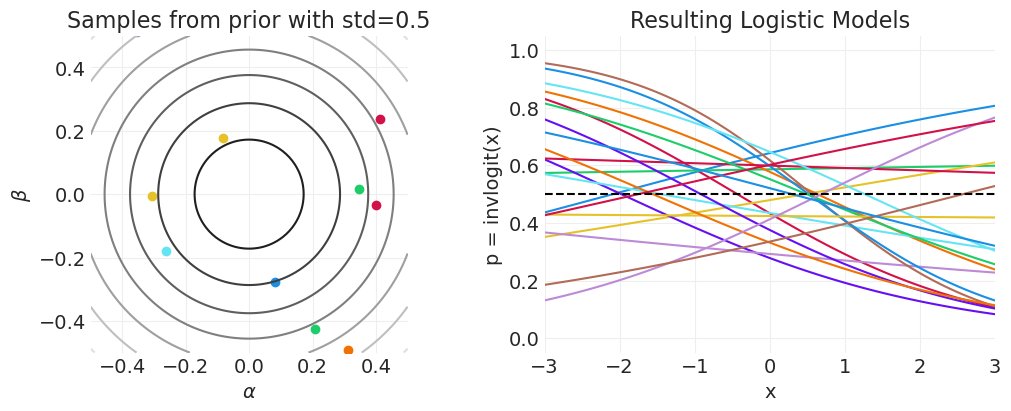

In [ ]:
plot_logistic_prior_predictive(prior_std=0.5)

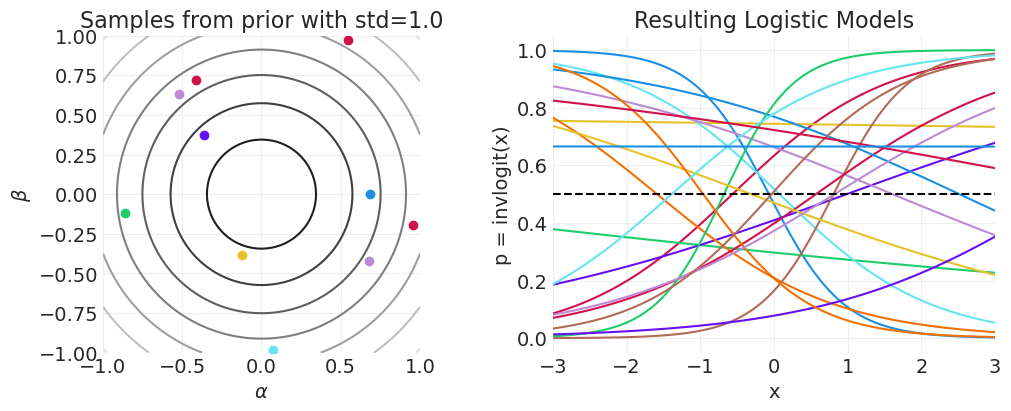

In [ ]:
plot_logistic_prior_predictive(prior_std=1.)

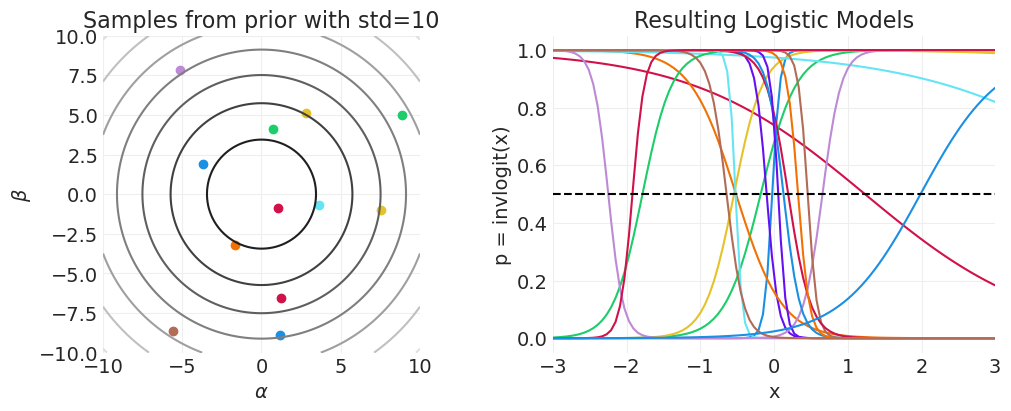

In [ ]:
plot_logistic_prior_predictive(prior_std=10)

## Statistical models for admissions
Again, the estimator will depend on the estimand

### Total Causal Effect

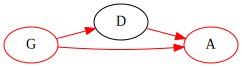

In [22]:
draw_causal_graph(
    edge_list=[
        ("G", "D"),
        ("G", "A"),
        ("D", "A")
    ],
    node_props={
        "G": {"color": "red"},
        "A": {"color": "red"},
    },
    edge_props={
        ("G", "A"): {"color": "red"},
        ("D", "A"): {"color": "red"},
        ("G", "D"): {"color": "red"}
    },
    graph_direction="LR"
)


**Stratify by only Gender**. Don't stratify by Department b.c. it's a Pipe (mediator) that we do not want to block

$$
\begin{align*}
A_i &\sim \text{Bernoulli}(p=p_i) \\
\text{logit}(p_i) &= \alpha[G_i] \\
\alpha &= [\alpha_0, \alpha_1] \\
\alpha_j &\sim \text{Normal}(0, 1)
\end{align*}
$$

### Direct Causal Effect

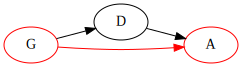

In [24]:
draw_causal_graph(
    edge_list=[
        ("G", "D"),
        ("G", "A"),
        ("D", "A")
    ],
    node_props={
        "G": {"color": "red"},
        "A": {"color": "red"},
    },
    edge_props={
        ("G", "A"): {"color": "red"}
    },
    graph_direction="LR"
)


**Stratify by Gender and Department** to block the Pipe

$$
\begin{align*}
A_i &\sim \text{Bernoulli}(p_i) \\
\text{logit}(p_i) &= \alpha[G_i, D_i] \\
\alpha &= \left[{\begin{array}{cc} \alpha_{0,0}, \alpha_{0,1} \\ \alpha_{1,0}, \alpha_{1,1} \end{array}}\right] \\
\alpha_{j,k} &\sim \text{Normal}(0, 1)
\end{align*}
$$

### Fitting Total Causal Effect Model

In [25]:
def fit_total_effect_model_admissions(data):
    """Fit total effect model, stratifying by gender.

    Note
    ----
    We use the Binomial regression, so simulated observation-level
    data from above must be pre-aggregated. (see the function
    `aggregate_admissions_data` below). We could have
    used a Bernoulli likelihood (Logistic regression) for the simulated
    data, but given that we only have aggregates for the real
    UC Berkeley data we choose this more general formulation.
    """

    # Set up observations / coords
    n_admitted = data['admit'].values
    n_applications = data['applications'].values

    gender_coded, gender = pd.factorize(data['applicant.gender'].values)

    with pm.Model(coords={"gender": gender}) as total_effect_model:

        # Mutable data for running any gender-based counterfactuals
        gender_coded = pm.MutableData("gender", gender_coded, dims="obs_ids")

        alpha = pm.Normal('alpha', 0, 1, dims="gender")

        # Record the inverse linked probabilities for reporting
        pm.Deterministic("p_accept", pm.math.invlogit(alpha), dims='gender')

        p = pm.math.invlogit(alpha[gender_coded])

        likelihood = pm.Binomial("accepted", n=n_applications, p=p, observed=n_admitted, dims="obs_ids")
        total_effect_inference = pm.sample()

    return total_effect_model, total_effect_inference

def aggregate_admissions_data(raw_admissions_data):
    """Aggregate simulated data from `simulate_admissions_data`, which
    is in long format to short format, by so that it can be modeled
    using Binomial likelihood. We also recode column names to have the
    same fields as the UC Berkeley dataset so that we can use the
    same model-fitting functions.
    """

    # Aggregate applications, admissions, and rejections. Rename
    # columns to have the  same fields as UC Berkeley dataset
    applications = raw_admissions_data.groupby(["gender", "department"]).count().reset_index()
    applications.rename(columns={"accepted": "applications"}, inplace=True)

    admits = raw_admissions_data.groupby(["gender", "department"]).sum().reset_index()
    admits.rename(columns={"accepted": "admit"}, inplace=True)

    data = applications.merge(admits)
    data.loc[:, "reject"] = data.applications - data.admit

    # Code gender & department. For easier comparison to lecture,
    # we use 1-indexed gender/department indicators like McElreath
    data.loc[:, "applicant.gender"] = data.gender.apply(lambda x: 2 if x else 1)
    data.loc[:, "dept"] = data.department.apply(lambda x: 2 if x else 1)

    return data[["applicant.gender", "dept", "applications", "admit", "reject"]]

def plot_admissions_model_posterior(inference, figsize=(6, 2)):
    _, ax = plt.subplots(figsize=figsize)

    # Plot alphas
    az.plot_forest(inference, var_names=['alpha'], combined=True, hdi_prob=.89, ax=ax);

    # Plot inver-linked acceptance probabilities
    _, ax = plt.subplots(figsize=figsize)
    az.plot_forest(inference, var_names=['p_accept'], combined=True, hdi_prob=.89, ax=ax);

    return az.summary(inference)

### Fit Total Effect model on BIASED simulated admissions

In [ ]:
SIMULATED_BIASED_ADMISSIONS, _ = simulate_admissions_data("biased")
SIMULATED_BIASED_ADMISSIONS = aggregate_admissions_data(SIMULATED_BIASED_ADMISSIONS)
SIMULATED_BIASED_ADMISSIONS

,applicant.gender,dept,applications,admit,reject
0,1,1,335,13,322
1,1,2,173,34,139
2,2,1,106,11,95
3,2,2,386,108,278


In [ ]:
total_effect_model_simulated_biased, total_effect_inference_simulated_biased = fit_total_effect_model_admissions(SIMULATED_BIASED_ADMISSIONS)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[1],-2.243,0.152,-2.541,-1.985,0.002,0.002,4029.0,2615.0,1.0
alpha[2],-1.131,0.104,-1.334,-0.942,0.002,0.001,3789.0,2897.0,1.0
p_accept[1],0.097,0.013,0.071,0.119,0.000,0.000,4029.0,2615.0,1.0
p_accept[2],0.244,0.019,0.208,0.280,0.000,0.000,3789.0,2897.0,1.0


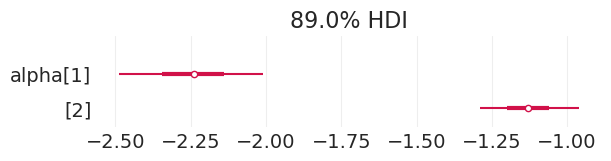

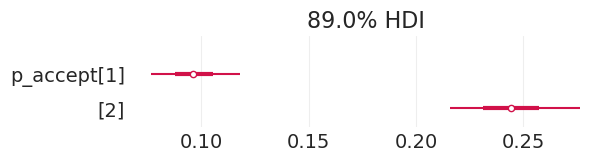

In [ ]:
plot_admissions_model_posterior(total_effect_inference_simulated_biased, (6, 1.5))

### Fit Total Effect model on UNBIASED simulated admissions

In [ ]:
SIMULATED_UNBIASED_ADMISSIONS, _ = simulate_admissions_data("unbiased")
SIMULATED_UNBIASED_ADMISSIONS = aggregate_admissions_data(SIMULATED_UNBIASED_ADMISSIONS)
SIMULATED_UNBIASED_ADMISSIONS

,applicant.gender,dept,applications,admit,reject
0,1,1,335,33,302
1,1,2,173,60,113
2,2,1,106,8,98
3,2,2,386,111,275


In [ ]:
total_effect_model_simulated_unbiased, total_effect_inference_simulated_unbiased = fit_total_effect_model_admissions(SIMULATED_UNBIASED_ADMISSIONS)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[1],-1.477,0.111,-1.682,-1.264,0.002,0.001,4108.0,3081.0,1.0
alpha[2],-1.131,0.104,-1.322,-0.930,0.002,0.001,4050.0,2757.0,1.0
p_accept[1],0.186,0.017,0.155,0.217,0.000,0.000,4108.0,3081.0,1.0
p_accept[2],0.245,0.019,0.211,0.283,0.000,0.000,4050.0,2757.0,1.0


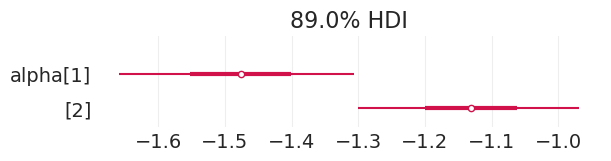

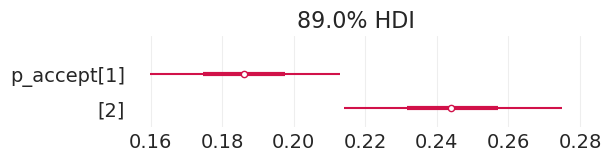

In [ ]:
plot_admissions_model_posterior(total_effect_inference_simulated_unbiased, (6, 1.5))

## Fitting Direct Causal Effect Model

In [ ]:
def fit_direct_effect_model_admissions(data):
    """Fit total effect model, stratifying by gender.

    Note
    ----
    We use the Binomial likelihood, so simulated observation-level data from
    above must be pre-aggregated. (see the function `aggregate_admissions_data`
    below). We could have used a Bernoulli likelihood for the simulated data,
    but given that we only have aggregates for the real UC Berkeley data we
    choose this more general formulation.
    """

    # Set up observations / coords
    n_admitted = data['admit'].values
    n_applications = data['applications'].values

    department_coded, department = pd.factorize(data['dept'].values)
    gender_coded, gender = pd.factorize(data['applicant.gender'].values)

    with pm.Model(coords={"gender": gender, "department": department}) as direct_effect_model:

        # Mutable data for running any gender-based or department-based counterfactuals
        gender_coded = pm.MutableData("gender", gender_coded, dims="obs_ids")
        department_coded = pm.MutableData("department", department_coded, dims="obs_ids")
        n_applications = pm.MutableData("n_applications", n_applications, dims="obs_ids")

        alpha = pm.Normal('alpha', 0, 1, dims=["department", "gender"])

        # Record inverse linked probabilities for reporting
        pm.Deterministic("p_accept", pm.math.invlogit(alpha), dims=['department', 'gender'])

        p = pm.math.invlogit(alpha[department_coded, gender_coded])

        likelihood = pm.Binomial("accepted", n=n_applications, p=p, observed=n_admitted, dims="obs_ids")
        direct_effect_inference = pm.sample()

    return direct_effect_model, direct_effect_inference

### Fit Direct Effect model to BIASED simulated admissions data

In [ ]:
direct_effect_model_simulated_biased, direct_effect_inference_simulated_biased = fit_direct_effect_model_admissions(SIMULATED_BIASED_ADMISSIONS)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"alpha[1, 1]",-3.019,0.249,-3.518,-2.589,0.003,0.002,7225.0,3385.0,1.0
"alpha[1, 2]",-1.997,0.289,-2.522,-1.449,0.004,0.003,6188.0,3104.0,1.0
"alpha[2, 1]",-1.366,0.187,-1.716,-1.022,0.002,0.002,6913.0,2874.0,1.0
"alpha[2, 2]",-0.936,0.110,-1.138,-0.726,0.001,0.001,6056.0,2707.0,1.0
"p_accept[1, 1]",0.048,0.011,0.027,0.068,0.000,0.000,7225.0,3385.0,1.0
"p_accept[1, 2]",0.123,0.030,0.069,0.182,0.000,0.000,6188.0,3104.0,1.0
"p_accept[2, 1]",0.205,0.030,0.152,0.264,0.000,0.000,6913.0,2874.0,1.0
"p_accept[2, 2]",0.282,0.022,0.243,0.326,0.000,0.000,6056.0,2707.0,1.0


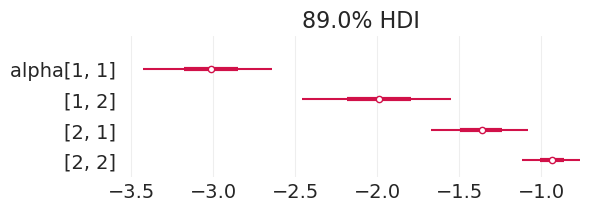

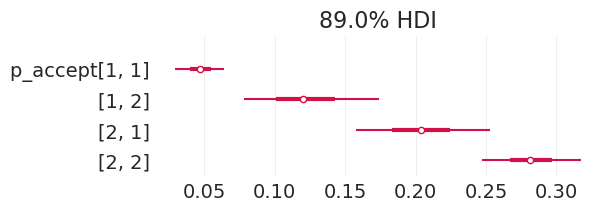

In [ ]:
plot_admissions_model_posterior(direct_effect_inference_simulated_biased)

For comparison, here's the ground truth biased admission rates, which we're able to mostly recover:

In [ ]:
# Department x Gender
BIASED_ACCEPTANCE_RATES

array([[0.05, 0.1 ],
       [0.2 , 0.3 ]])

### Fit Direct Effect model to UNBIASED simulated admissions data

In [ ]:
direct_effect_model_simulated_unbiased, direct_effect_inference_simulated_unbiased = fit_direct_effect_model_admissions(SIMULATED_UNBIASED_ADMISSIONS)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"alpha[1, 1]",-2.153,0.177,-2.504,-1.843,0.002,0.002,6406.0,3520.0,1.0
"alpha[1, 2]",-2.270,0.314,-2.843,-1.664,0.004,0.003,6302.0,3416.0,1.0
"alpha[2, 1]",-0.621,0.158,-0.908,-0.313,0.002,0.001,8119.0,3357.0,1.0
"alpha[2, 2]",-0.898,0.112,-1.104,-0.685,0.001,0.001,6498.0,3123.0,1.0
"p_accept[1, 1]",0.105,0.017,0.076,0.137,0.000,0.000,6406.0,3520.0,1.0
"p_accept[1, 2]",0.097,0.027,0.049,0.148,0.000,0.000,6302.0,3416.0,1.0
"p_accept[2, 1]",0.350,0.036,0.282,0.417,0.000,0.000,8119.0,3357.0,1.0
"p_accept[2, 2]",0.290,0.023,0.249,0.335,0.000,0.000,6498.0,3123.0,1.0


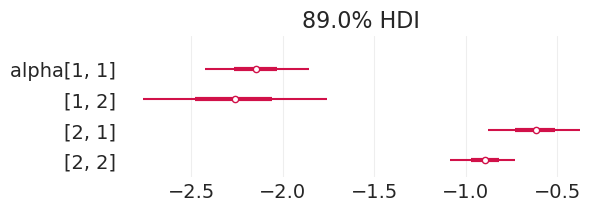

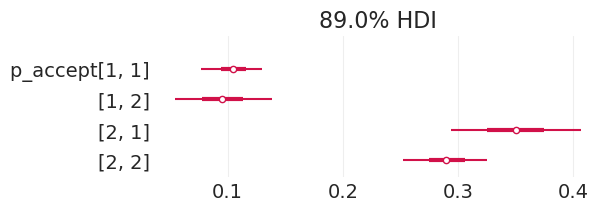

In [ ]:
plot_admissions_model_posterior(direct_effect_inference_simulated_unbiased)

For comparison, here's the ground truth unbiased admission rates, which were able to recover:

In [ ]:
# Department x Gender
UNBIASED_ACCEPTANCE_RATES

array([[0.1, 0.1],
       [0.3, 0.3]])

# 4. Analyze the UC Berkeley Admissions data

### Review of the counts dataset
- we'll use these counts data to model log odds of acceptance rate for gender/department
- note that we'll be using Binomial Regression, which is equivalent to Bernoulli regression, but operates on aggregate counts, as oppose to individual binary trials
  - The examples above were actually implemented as Binomial Regression so that we can re-use code and demonstrate general patterns of analysis
  - Either way, you'll get the same inference using both approaches

In [ ]:
ADMISSIONS

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325
6,C,female,202,391,593
7,D,male,138,279,417
8,D,female,131,244,375
9,E,male,53,138,191
10,E,female,94,299,393


### Fit Total Effect model to UC Berkeley admissions data

> Don't forget to look at diagnostics, which we'll skip here

In [ ]:
total_effect_model, total_effect_inference = fit_total_effect_model_admissions(ADMISSIONS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[male],-0.219,0.040,-0.290,-0.143,0.001,0.000,3863.0,3055.0,1.0
alpha[female],-0.828,0.051,-0.922,-0.730,0.001,0.001,3797.0,2838.0,1.0
p_accept[male],0.446,0.010,0.428,0.464,0.000,0.000,3863.0,3055.0,1.0
p_accept[female],0.304,0.011,0.284,0.325,0.000,0.000,3797.0,2838.0,1.0


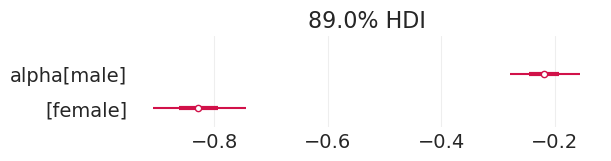

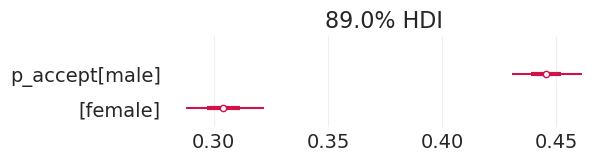

In [ ]:
plot_admissions_model_posterior(total_effect_inference, figsize=(6, 1.5))

### Total Causal Effect

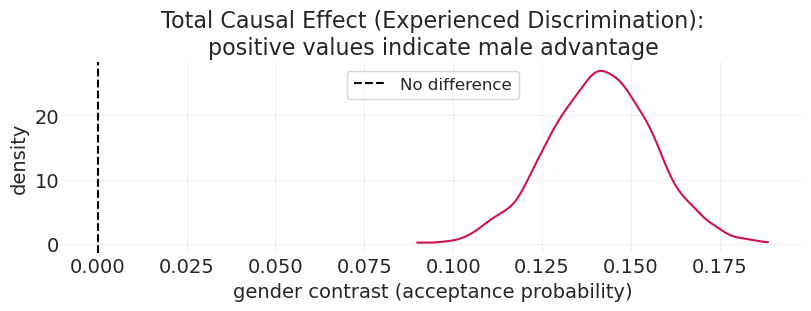

In [ ]:
# Total Causal Effect
female_p_accept = total_effect_inference.posterior["p_accept"].sel(gender="female")
male_p_accept = total_effect_inference.posterior["p_accept"].sel(gender="male")
contrast = male_p_accept - female_p_accept

plt.subplots(figsize=(8, 3))
az.plot_dist(contrast)
plt.axvline(0, linestyle="--", color='black', label='No difference')
plt.xlabel("gender contrast (acceptance probability)")
plt.ylabel("density")
plt.title("Total Causal Effect (Experienced Discrimination):\npositive values indicate male advantage")
plt.legend();

### Fit Direct Effect model to UC Berkeley admissions data

In [ ]:
direct_effect_model, direct_effect_inference = fit_direct_effect_model_admissions(ADMISSIONS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"alpha[A, male]",0.489,0.072,0.352,0.625,0.001,0.001,6128.0,3015.0,1.0
"alpha[A, female]",1.468,0.244,0.996,1.920,0.003,0.002,6029.0,2913.0,1.0
"alpha[B, male]",0.529,0.088,0.372,0.707,0.001,0.001,5906.0,3012.0,1.0
"alpha[B, female]",0.659,0.400,-0.090,1.383,0.005,0.005,6284.0,2812.0,1.0
"alpha[C, male]",-0.531,0.118,-0.745,-0.301,0.002,0.001,5715.0,3112.0,1.0
"alpha[C, female]",-0.656,0.086,-0.821,-0.491,0.001,0.001,6763.0,3339.0,1.0
"alpha[D, male]",-0.698,0.102,-0.888,-0.504,0.001,0.001,5807.0,3198.0,1.0
"alpha[D, female]",-0.616,0.109,-0.821,-0.418,0.001,0.001,5522.0,3186.0,1.0
"alpha[E, male]",-0.935,0.161,-1.241,-0.630,0.002,0.001,6677.0,2688.0,1.0
"alpha[E, female]",-1.145,0.120,-1.356,-0.914,0.002,0.001,5867.0,2703.0,1.0


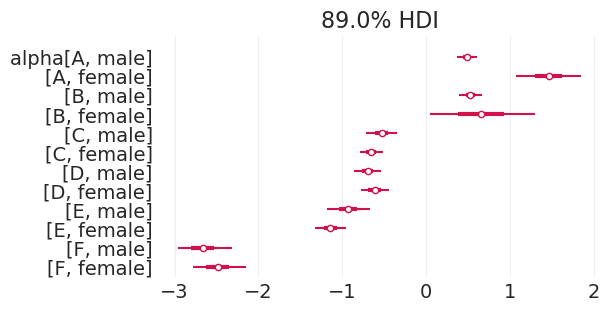

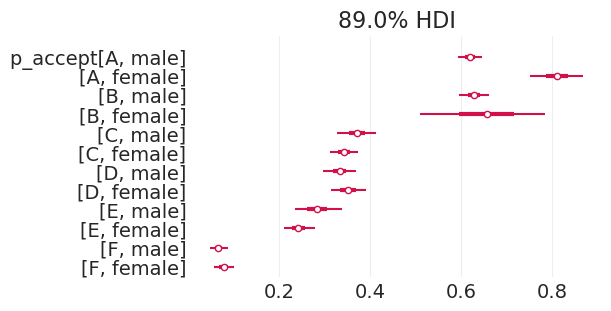

In [ ]:
plot_admissions_model_posterior(direct_effect_inference, figsize=(6, 3))

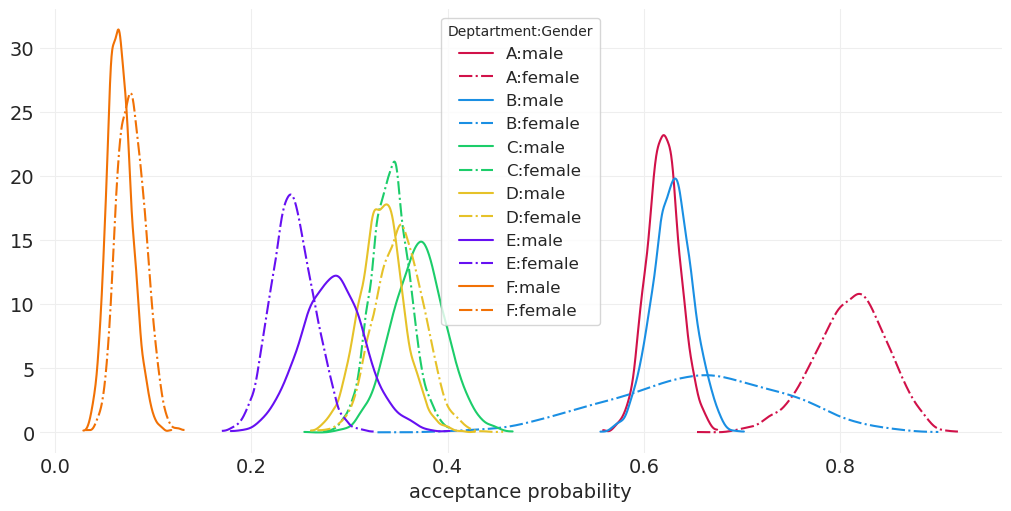

In [ ]:
# Fancier plot of department/gender acceptance probability distributions
_, ax = plt.subplots(figsize=(10, 5))
for ii, dept in enumerate(ADMISSIONS.dept.unique()):
    color = f"C{ii}"
    for gend in ADMISSIONS["applicant.gender"].unique():
        label = f"{dept}:{gend}"
        linestyle = "-." if gend == 'female' else "-"
        post = direct_effect_inference.posterior['p_accept'].sel(department=dept, gender=gend)
        az.plot_dist(post, label=label, color=color, plot_kwargs={"linestyle": linestyle})
plt.xlabel("acceptance probability");
plt.legend(title='Deptartment:Gender');

### Direct Causal Effect

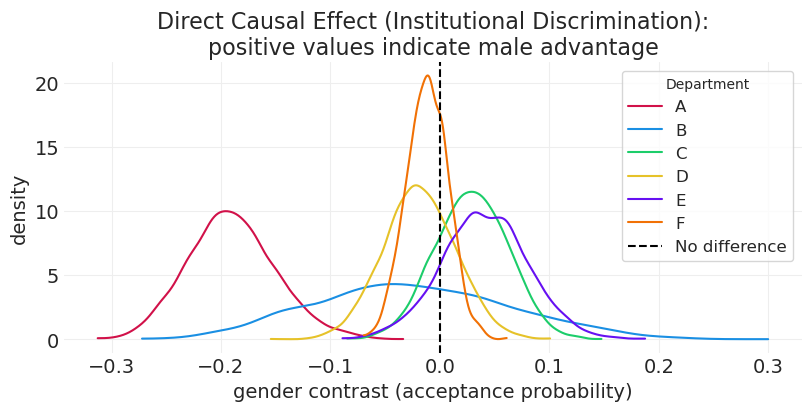

In [ ]:
# Direct Causal Effect
_, ax = plt.subplots(figsize=(8, 4))

for ii, dept in enumerate(ADMISSIONS.dept.unique()):
    color = f"C{ii}"
    label = f"{dept}"

    female_p_accept = direct_effect_inference.posterior["p_accept"].sel(gender="female", department=dept)
    male_p_accept = direct_effect_inference.posterior["p_accept"].sel(gender="male", department=dept)

    contrast = male_p_accept - female_p_accept
    az.plot_dist(contrast, color=color, label=label)

plt.xlabel("gender contrast (acceptance probability)")
plt.ylabel("density")
plt.title("Direct Causal Effect (Institutional Discrimination):\npositive values indicate male advantage")
plt.axvline(0, linestyle="--", color='black', label='No difference');
plt.legend(title='Department');

### Average Direct Effect
- The causal effect of gender **averaged across departments** (marginalize)
- Depends on the distribution of applications to each deparment
- This is easy to do as a simulation

#### Post-stratification
- **Re-weight estimates** for the target population
- allows us to apply model fit from one university to estiamte causal impact at another university with a different distribution of departments
- Here, we use the empirical distribution for re-weighting estimates

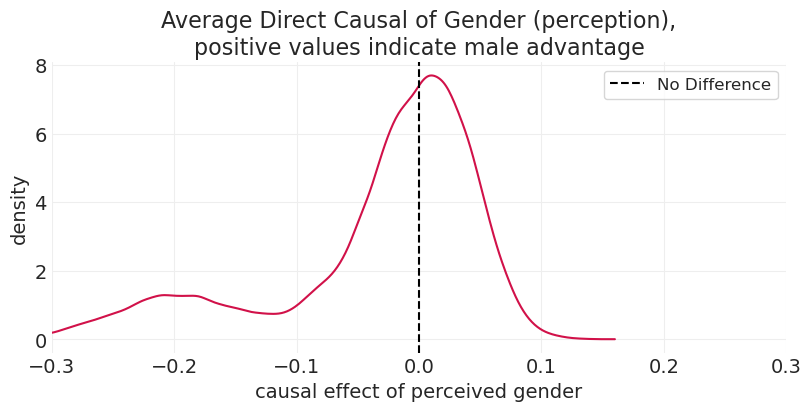

In [ ]:
# Use the empirical distribution of departments -- we'd update this for a different university
applications_per_dept = ADMISSIONS.groupby('dept').sum()['applications'].values
total_applications = applications_per_dept.sum()
department_weight = applications_per_dept / total_applications

female_alpha = direct_effect_inference.posterior.sel(gender='female')['alpha']
male_alpha = direct_effect_inference.posterior.sel(gender='male')['alpha']

weighted_female_alpha = female_alpha * department_weight
weighed_male_alpha = male_alpha * department_weight

contrast = weighed_male_alpha - weighted_female_alpha

_, ax = plt.subplots(figsize=(8, 4))
az.plot_dist(contrast)

plt.axvline(0, linestyle='--', color='k', label='No Difference')
plt.xlabel("causal effect of perceived gender")
plt.ylabel("density")
plt.title("Average Direct Causal of Gender (perception),\npositive values indicate male advantage");
plt.xlim([-.3, .3])
plt.legend();

To verify the averaging process, we can look at the contrast of the `p_accept` samples from the posterior, which provides similar results. However, looking ath the posterior obviously wouldn't work for making predictions for an out-of-sample university however.

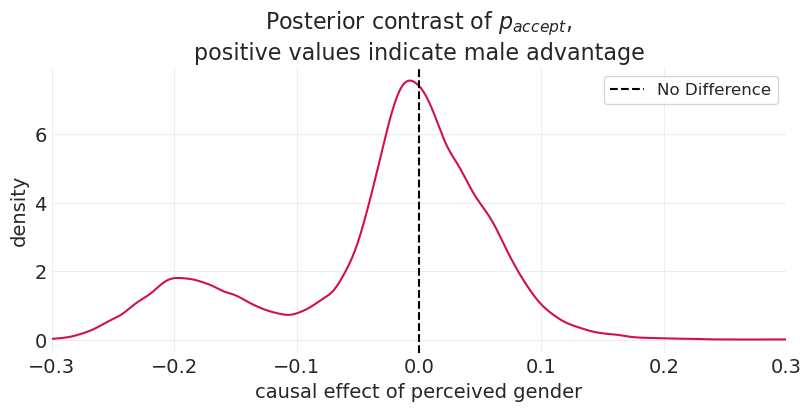

In [ ]:
direct_posterior = direct_effect_inference.posterior

# Select by gender; note: p_accept already has link function applied
female_posterior = direct_posterior.sel(gender='female')['p_accept']  # shape: (chain x draw x department)
male_posterior = direct_posterior.sel(gender='male')['p_accept'] # shape: (chain x draw x department)
contrast = male_posterior - female_posterior # shape: (chain x draw x department)

_, ax = plt.subplots(figsize=(8, 4))
# marginalize / collapse the contrast across all departments
az.plot_dist(contrast);
plt.axvline(0, linestyle='--', color='k', label='No Difference')
plt.xlim([-.3, .3])
plt.xlabel("causal effect of perceived gender")
plt.ylabel("density")
plt.title("Posterior contrast of $p_{accept}$,\npositive values indicate male advantage");
plt.legend();

## Discrimination?
Hard to say
- Big structural effects
- Distribution of applicants could be due to discrimination
- **Confounds are likely**

# BONUS: Survival Analysis
- Counts often modeled as time-to-event (i.e. Exponential or Gamma distribution)  -- Goal is to estimate event rate
- Tricky b.c. ignoring **censored data** can lead to inferential errors
  - **Left censored**: we don't know when the timer started
  - **Right censored** the observation period finished before the event had time to happen

## Example: Austin Cat Adoption

- 20k cats
- Events: adopted (1) or not (0)
- Censoring mechanisms
  - death before adoption
  - escape
  - not adopted yet

**Goal**: determine if Black are adopted at a lower rate than non-Black cats.

In [ ]:
CATS = utils.load_data('AustinCats')
CATS.head()

,id,days_to_event,date_out,out_event,date_in,in_event,breed,color,intake_age
0,A730601,1,07/08/2016 09:00:00 AM,Transfer,07/07/2016 12:11:00 PM,Stray,Domestic Shorthair Mix,Blue Tabby,7
1,A679549,25,06/16/2014 01:54:00 PM,Transfer,05/22/2014 03:43:00 PM,Stray,Domestic Shorthair Mix,Black/White,1
2,A683656,4,07/17/2014 04:57:00 PM,Adoption,07/13/2014 01:20:00 PM,Stray,Snowshoe Mix,Lynx Point,2
3,A709749,41,09/22/2015 12:49:00 PM,Transfer,08/12/2015 06:29:00 PM,Stray,Domestic Shorthair Mix,Calico,12
4,A733551,9,09/01/2016 12:00:00 AM,Transfer,08/23/2016 02:35:00 PM,Stray,Domestic Shorthair Mix,Brown Tabby/White,1


### Modeling outcome variable: `days_to_event`
Two go-to distributions for modeling time-to-event

**Exponential Distribution**:
- simpler of the two (single parameter)
- assumes constant rate
- maximum entropy distribution amongst the set of non-negative continuous distributions that have the same average rate.
- assumes a single thing to occur (e.g. part failure) before an event occurs (machine breakdown)

**Gamma Distribution**
- more complex of the two (two parameters)
- maximum entropy distribution amongst the set of distributions with the same mean and average log.
- assumes multiple things to happen (e.g. part failures) before an event occurs (machine breakdown)

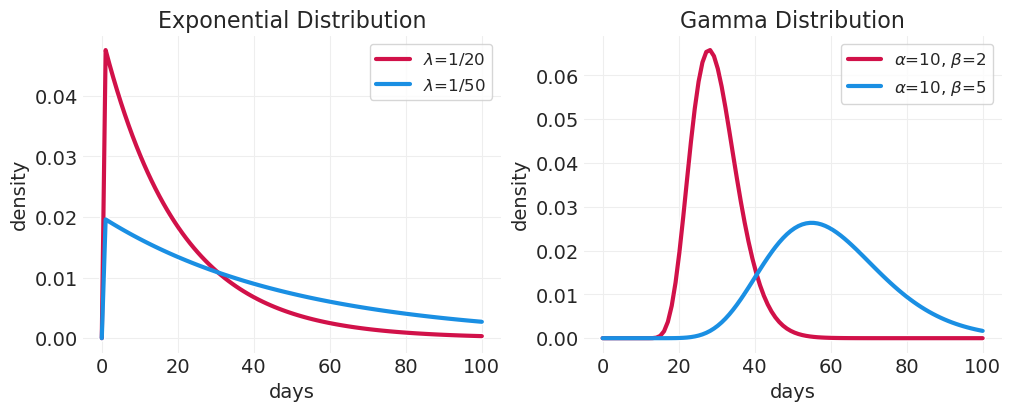

In [ ]:
_, axs = plt.subplots(1, 2, figsize=(10, 4))

days = np.linspace(0, 100, 100)

plt.sca(axs[0])
for scale in [20, 50]:
    expon = stats.expon(loc=.01, scale=scale)
    utils.plot_line(days, expon.pdf(days), label=f"$\\lambda$=1/{scale}")
plt.xlabel("days")
plt.ylabel("density")
plt.legend()
plt.title("Exponential Distribution")


plt.sca(axs[1])
N = 8
alpha=10
for scale in [2, 5]:
    gamma = stats.gamma(a=10, loc=alpha, scale=scale)
    utils.plot_line(days, gamma.pdf(days), label=f"$\\alpha$={alpha}, $\\beta$={scale}")
plt.xlabel("days")
plt.ylabel("density")
plt.legend();
plt.title("Gamma Distribution");


## Censored and un-censored observations
- Observed data use the Cumulative distribution; i.e. the **probability that the event occurred by time x**
- Unobserved (censored) data instead require the Complementary of the CDF; i.e. the **probability that the event hasn't happened yet**.

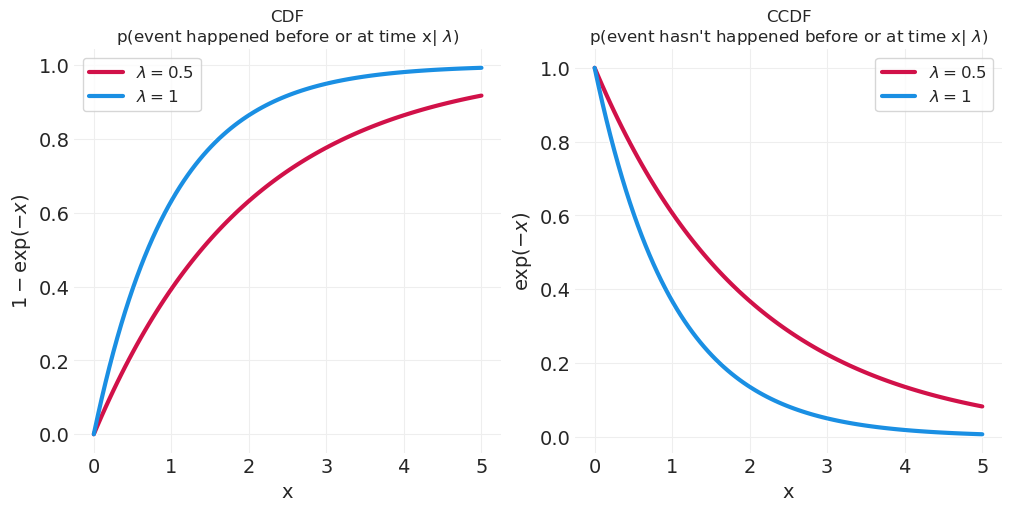

In [ ]:
xs = np.linspace(0, 5, 100)
_, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(axs[0])
cdfs = {}
for lambda_ in [0.5, 1]:
    cdfs[lambda_] = ys = 1 - np.exp(-lambda_ * xs)
    utils.plot_line(xs, ys, label=f"$\\lambda={lambda_}$")

plt.xlabel("x")
plt.ylabel("$1 - \\exp(-x)$")
plt.legend()
plt.title("CDF\np(event happened before or at time x| $\\lambda$)", fontsize=12)

plt.sca(axs[1])
for lambda_ in [0.5, 1]:
    ys = 1 - cdfs[lambda_]
    utils.plot_line(xs, ys, label=f"$\\lambda={lambda_}$")

plt.xlabel("x")
plt.ylabel("$\\exp(-x)$")
plt.legend()
plt.title("CCDF\np(event hasn't happened before or at time x| $\\lambda$)", fontsize=12);

## Statistical Model

$$
\begin{align*}
D_i | A_i &= 1 \sim \text{Exponential}(\lambda_i) \\
D_i | A_i &= 0 \sim \text{ExponentialCCDF}(\lambda_i) \\
\lambda_i &= \frac{1}{\mu_i} \\
\log \mu_i &= \alpha_{\text{cat color}[i]} \\
\alpha_{Black, Other} &\sim \text{Exponential}(\gamma)
\end{align*}
$$

- $D_i | A_i = 1$ - observed adoptions
- $D_i | A_i = 1$ - not-yet-observed adoptions
- $\alpha_{\text{cat color}[i]}$ log average time-to-adoption for each cat color
- $\log \mu_i$ -- link function ensures $\alpha$s are positive
- $\lambda_i = \frac{1}{\mu_i}$ simplifies estimating average **time-to-adoption**

### Finding reasonable hyperparameter for $\alpha$
We'll need to determine a reasonable data for the Exponential prior mean parameter $\gamma$. To do so, we'll look at the empirical distribution of time to adoption:

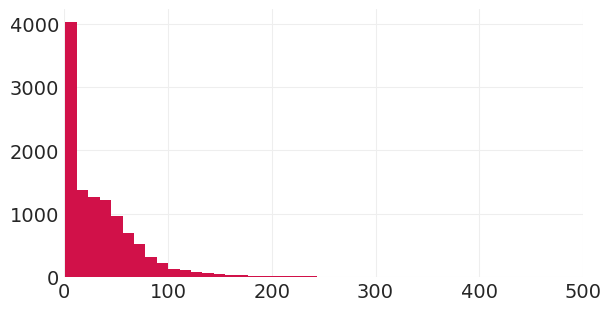

In [ ]:
# determine reasonable prior for alpha
plt.subplots(figsize=(6, 3))
CATS[CATS.out_event == 'Adoption'].days_to_event.hist(bins=100)
plt.xlim([0, 500]);

Using the above empirical historgram, we see that a majority of the probablity mass is between zero and 200, so let's use 50 as the expected wait time.

In [ ]:
CAT_COLOR_ID, CAT_COLOR = pd.factorize(CATS.color.apply(lambda x: "Other" if x != 'Black' else x))
ADOPTED_ID, ADOPTED = pd.factorize(CATS.out_event.apply(lambda x: "Other" if x != "Adoption" else 'Adopted'))
DAYS_TO_ADOPTION = CATS.days_to_event.values.astype(float)
LAMBDA = 50

with pm.Model(coords={"cat_color": CAT_COLOR}) as adoption_model:

    # Censoring
    right_censoring = DAYS_TO_ADOPTION.copy()
    right_censoring[ADOPTED_ID == 0] = DAYS_TO_ADOPTION.max()

    # Priors
    gamma = 1 / LAMBDA
    alpha = pm.Exponential("alpha", gamma, dims="cat_color")

    # Likelihood
    log_adoption_rate = 1 / alpha[CAT_COLOR_ID]
    pm.Censored(
        "adopted",
        pm.Exponential.dist(lam=log_adoption_rate),
        lower=None,
        upper=right_censoring,
        observed=DAYS_TO_ADOPTION
    )
    adoption_inference = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


## Poor black kittes 🐈‍⬛
It appears that black cats DO take longer to get adopted.

#### Posterior Summary

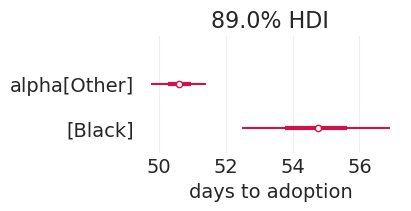

In [ ]:
_, ax = plt.subplots(figsize=(4, 2))
az.plot_forest(adoption_inference, var_names=['alpha'], combined=True, hdi_prob=.89, ax=ax)
plt.xlabel("days to adoption");

#### Posterior distributions

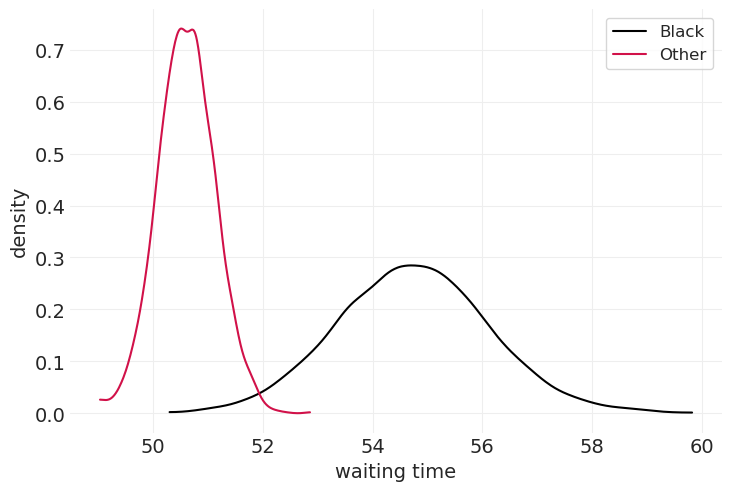

In [ ]:
for ii, cat_color in enumerate(["Black", "Other"]):
    color = 'black' if cat_color == 'Black' else "C0"
    posterior_alpha = adoption_inference.posterior.sel(cat_color=cat_color)['alpha']
    az.plot_dist(posterior_alpha, color=color, label=cat_color)
plt.xlabel("waiting time")
plt.ylabel("density")
plt.legend();

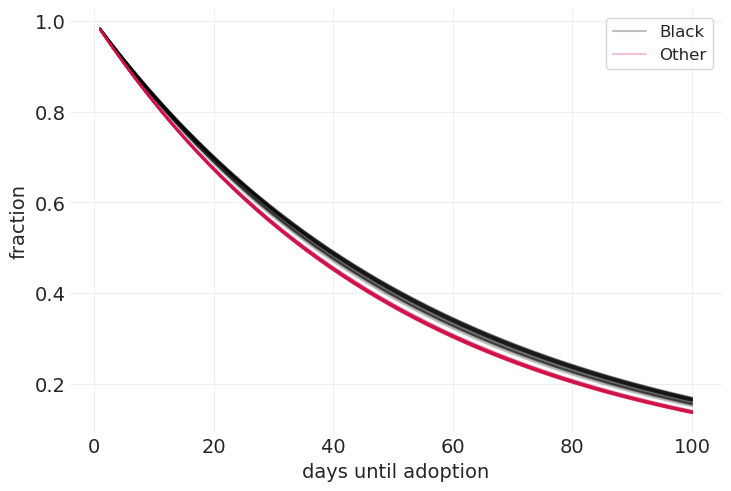

In [ ]:
days_until_adoption_ = np.linspace(1, 100)
n_posterior_samples = 25

for cat_color in ['Black', 'Other']:
    color = "black" if cat_color == 'Black' else "C0"
    posterior = adoption_inference.posterior.sel(cat_color=cat_color)
    alpha_samples = posterior.alpha.sel(chain=0)[:n_posterior_samples].values
    for ii, alpha in enumerate(alpha_samples):
        label = cat_color if ii == 0 else None
        plt.plot(days_until_adoption_, np.exp(-days_until_adoption_/alpha), color=color, alpha=.25, label=label)

plt.xlabel("days until adoption")
plt.ylabel("fraction");
plt.legend();